## Customer segmentation using k-means method ##

**About the project**  
The online home goods store “While Still Here” helps customers furnish the home of their dreams. Their slogan says: “While everything is still here” - we create comfort!

To build their work more efficiently, they need a full analysis of the product range, and most importantly, to identify customer profiles.

**Task:**
* Divide unstructured product names on categories
* Segment buyers by consumption profile
* Describe consumer groups
* Give recommendations for email marketing



**Work plan:**
1. Data pre-processing:
  - data type
  - remove duplicates
  - dividing products on categories
  - check outliers
2. EDA:
  - MAU
  - sales by month \ categories
  - averages and variances in data
3. Segmentation:
  - determining the number of segments by dendrogram
  - deviding customers on segments by k-means
  - checking the quality of segments (testing hypotheses about average values)
4. Segments description
5. Recommendations for email marketing activities

## Data ##

The original dataset describes online store transactions:  
- date — order date;
- customer_id — customer identifier;
- order_id — order identifier;
- product — name of the product;
- quantity — amount of the product in the order;
- price — product price.

## Data pre-processing ##

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st
import itertools
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings

In [2]:
try:
  sales = pd.read_csv('/content/drive/MyDrive/я.практикум/ECOM — Behavior/ecom_dataset_upd.csv')
except:
  sales = pd.read_csv('https://')


In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100
warnings.simplefilter(action='ignore', category=Warning)

In [4]:
sales.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


### Data type ###

Let's check the correctness of the data type for the columns.

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In the date column, we will convert the data type to date and leave only the date without time, and also check the period for which the data is presented.

In [6]:
sales['date'] = pd.to_datetime(sales['date'], format='%Y%m%d%H', errors='coerce')
print(f'Data is presented for the period from {sales["date"].min()} to {sales["date"].max()}')

Data is presented for the period from 2018-10-01 00:00:00 to 2020-01-31 15:00:00


In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7474 non-null   datetime64[ns]
 1   customer_id  7474 non-null   object        
 2   order_id     7474 non-null   int64         
 3   product      7474 non-null   object        
 4   quantity     7474 non-null   int64         
 5   price        7474 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 350.5+ KB


In [8]:
sales.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


### Gaps and duplicates ###

We conduct a dataset for gaps in the data

In [9]:
sales.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

There are no gaps.

Check data on the obvious duplicates.

In [10]:
sales.duplicated().mean()

0.0

There are no obvious duplicates.

Let's check the dataset for implicit duplicates in columns: customer_id,order_id,product,quantity,price.

In [11]:
sales.duplicated(['customer_id','order_id','product','quantity','price']).sum()

1864

In [12]:
sales[sales.duplicated(['customer_id','order_id','product','quantity','price'])].\
                        sort_values(by=['order_id', 'product']).head()

,date,customer_id,order_id,product,quantity,price
376,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.0
509,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.0
588,2018-11-02 14:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.0
758,2018-11-10 17:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.0
816,2018-11-15 15:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.0


In [13]:
sales = sales.drop_duplicates(subset=['customer_id','order_id','product','quantity','price'], keep='first')\
                                                                                    .reset_index(drop=True)

There are 1864 rows of implicit duplicates. We delete them frome out database.

In [14]:
sales.shape

(5610, 6)

Also there could be implicit duplicates in order 'id', if it was made by more than one customer.

In [15]:
moreone = sales.groupby('order_id')['customer_id'].nunique().reset_index().sort_values(by='customer_id',ascending=False)
moreone = moreone.query('customer_id > 1')
moreone.shape

(29, 2)

There are 29 orders, in which 2 or more cistomers on one bill.  
We'll remove duplicates.

In [16]:
#make a dataframe with unique combinations of order and buyer
pik2 = sales.groupby(['order_id','customer_id'])['quantity'].sum().reset_index()
#delete duplicate orders so that only 1 order-customer combination remains
pik2 = pik2.drop_duplicates(subset=['order_id'], keep='first').reset_index(drop=True)

In [17]:
#connect the dataframe with unique combinations of order-customer and sales,
#this way there will be no duplicates for 1 order - several buyers
sales = pd.merge(sales, pik2[['order_id', 'customer_id']], on=['order_id', 'customer_id'], how='inner')
sales.shape

(5575, 6)

In [18]:
7474-5574

1900

In [19]:
(7474-5574)/7474*100

25.42146106502542

After processing duplicates, 1900 values or 25.4% of the data were removed.

### Dividing products into categories ###

We manually select keywords for various categories and create a dictionary of lists, where the key is the name of the category, and the list contains keywords.

In [20]:
pd.set_option('display.max_rows', 20)

In [21]:
categories = {
'plants and seedlings':['комнатн', 'цветущ', 'пеларгония', 'герань', 'домашн', 'рассада', 'растение', \
                       'комнатное растение', 'Юкка', 'Шеффлера', 'Радермахера', 'Хризолидокарпус', ' сорт ',\
                       'Калатея', 'Мирт', 'd-12', 'd-13','фиалка','кашпо', 'Настурция', 'Эхеверия', 'Суккулент', \
                        'укроп', 'гвоздика','вербена', 'горш', 'кассет', 'нолина', 'петунья','d-7','d-10',\
                        'd-9','d-15', 'd-17', 'Эвкалипт', 'Хризантема', 'гипсофила', 'Калибрахоа',\
                        'базилик', 'петуния', '0,1 г', 'Бакопа', 'красавица','0,3 г', 'космея',\
                        'дерево Ель', 'черенок','роза', 'Эхинокактус', 'Ранункулус', 'Цинния', 'объем 1 л',\
                        'объем 0,5 л', 'арбуз', 'дыня', 'фуксия', 'клубника', 'калла', 'бегония', 'лобелия',\
                        'вербейник','осина', 'Алиссум', 'календула', 'лапчатка', 'морковь', 'земляника','Антуриум',\
                        'Гайлардия', 'виноград', 'Спатифиллум', 'пуансет', 'зверобо', 'рукола', 'петрушка', 'тюльпан',\
                     'кумкват', 'литопс', 'цикламен', 'хоста', 'рудбек', 'эшшольц', 'скиммия', 'Гимнокалициум', 'дендробиум',\
                     'смолевка', 'горох'],
'household products': ['сумка', 'стремян', 'ковер', 'ковёр', 'придверный','влаговпитывающ','Коврик хлопковый','постель',\
                    'Тележк', 'крючок', 'ящик', 'подставка', 'плед', 'наматрасник', 'простын', 'хранен', 'весы', \
                    'кофр', 'ключница', 'полк', 'обувница', 'наволочк', 'одеял', 'Коврик резиновый', 'фен', 'подголовник',\
                    'матрац','пуф','стеллаж', 'комод', 'мебел', 'этажер', 'подушк', 'покрыв', 'светильник', 'коврик'],
'cleaning products':['мусор','швабр','Щетка','Салфет','Пылесос', 'для мытья', 'средство','Перчатк', 'антижир',\
                    'губка', 'Тряп','Ведр', 'окномойка', 'веник', 'ткань', 'совок', 'совк','отбел', 'чистящий'],
'clothing care':['вешал','сушилка','белья','гладильн','чехол', 'таз ','Корзин', 'прищеп', 'утюг', 'ролик','Плечики',\
                  'глаж', 'подрукавник', 'стирк'],
'kitchen goods': ['Кухонн','противень', 'сковород', 'чайн', 'тарелк', 'скатерть', 'банка', 'ложка', 'нож', 'круж', 'вилка',\
                    'посуд', 'кувшин', 'Контейнер','интерьерный','выпеч', 'орехокол', 'котел', 'салатник', 'скребок', 'ковш',\
                    'фужер', 'сотейник','Luminarc','штопор', 'миксер', 'соус', 'варк', 'стакан','кастрюля',\
                    'термос ', 'раздел', 'свч', 'миска', 'венчик', 'хлебница', 'тортница', 'WEBBER', 'лопатка', 'чистка',\
                    'мялка', 'столовых', 'эмалирован', 'Пресс для', 'рассекатель', 'толкушка', 'просеяв', 'скалка',\
                    'половник', 'кипятиль', 'для муки', 'отделитель', 'соковыжим', 'сахар', 'блюдо', 'терк', 'лоток'],
'bath and toilet products':[' ванн','душев','противоскользящий','мыл', 'ёрш', 'Ерш', 'Вантуз', 'унитаз', 'халат', 'туалет',\
                              'полотен', 'штор', 'ванна', 'паста', 'увлажняю'],
'decor': ['декоратив', 'искусственн', 'муляж', 'коробка', 'Фото'],
'tools and stuff':['линейка','штангенциркуль','сверло','измерительн','термометр', 'шило','петля', 'инструмент','корыт',\
              'крепеж','напильн', 'шпагат', 'шнур',  'стяжка',  'скоба', 'бидон', 'насадка', 'фиксатор', 'шпигалет',\
                       'урна', 'основание', 'заверт', 'вентиляцион', 'зажиг', 'шпингалет', 'фал ',\
                        'Веревка полипропиленовая', 'уголок', 'сверел']}

We have created a dictionary of lists, now we go through it in a loop to put a category in a new column.

In [22]:
sales['category'] = None

for category, keywords in categories.items():
    mask = sales['product'].str.contains('|'.join(keywords), case=False)
    sales.loc[mask, 'category'] = category


In [23]:
sales['category'].isna().sum()

0

In [24]:
cat = sales.groupby('category')['product'].nunique().reset_index()
cat

,category,product
0,bath and toilet products,156
1,cleaning products,82
2,clothing care,382
3,decor,143
4,household products,263
5,kitchen goods,351
6,plants and seedlings,897
7,tools and stuff,68


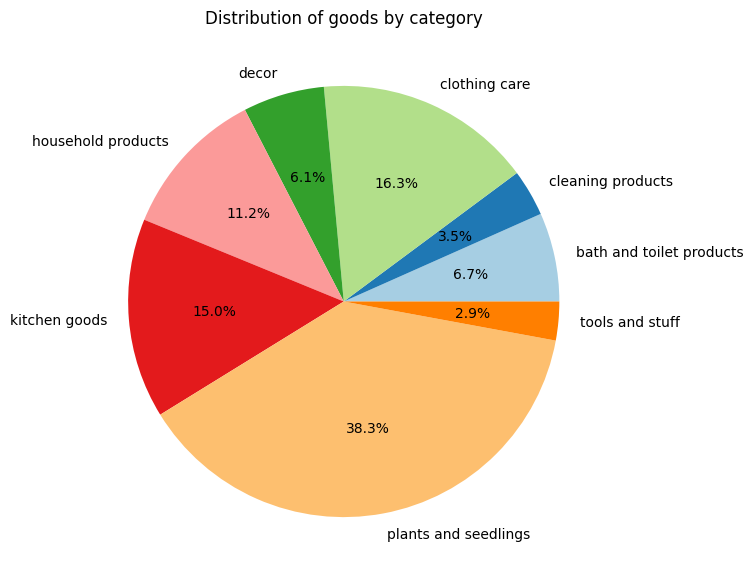

In [25]:
plt.figure(figsize=(7, 7))
plt.pie(x=cat['product'], labels=cat['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Distribution of goods by category')
plt.show();

### Calculation of additional columns ###

Let's calculate additional values for segmentation and working with outliers:
- cost per product in order
- amount of purchases per client
- number of orders
- number of product units
- number of categories
- average bill
- the average cost per unit of goods purchased.

In [26]:
#calculate the total cost of the product in the order
sales['item_ttl_price'] = sales['quantity'] * sales['price']

Let's create a dataframe with data grouped by client id.

In [27]:
customers = sales.pivot_table(index='customer_id', values=['order_id','product','quantity','item_ttl_price','category'],\
                 aggfunc={'order_id': 'nunique',
                         'product':'count',
                         'quantity':'sum',
                         'item_ttl_price':'sum',
                         'category':'nunique'}).reset_index()

In [28]:
#rename the columns to make their content clearer
customers.columns = ['customer_id','category_cnt', 'price_ttl','orders_cnt','product_cnt', 'items_ttl']
customers.head()

,customer_id,category_cnt,price_ttl,orders_cnt,product_cnt,items_ttl
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,1,4,4
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,1,1,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,1,1,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,1,1,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,1,1,2


In [29]:
customers['avg_bill'] = customers['price_ttl'] / customers['orders_cnt']
customers['avg_item_price'] = customers['price_ttl'] / customers['items_ttl']
customers.head()

,customer_id,category_cnt,price_ttl,orders_cnt,product_cnt,items_ttl,avg_bill,avg_item_price
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,1,4,4,555.0,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,1,1,1,442.0,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,1,1,2,914.0,457.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,1,1,1,1649.0,1649.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,1,1,2,2324.0,1162.00


### Outliers ###

In [30]:
customers.describe()

,category_cnt,price_ttl,orders_cnt,product_cnt,items_ttl,avg_bill,avg_item_price
count,2432.000000,2432.000000,2432.00000,2432.000000,2432.000000,2432.000000,2432.000000
mean,1.290707,1900.530188,1.44778,2.292352,5.934622,1451.381372,709.211789
std,0.524775,14323.171111,2.68789,4.385906,27.069244,13824.808104,1024.930009
min,1.000000,15.000000,1.00000,1.000000,1.000000,15.000000,14.000000
25%,1.000000,394.500000,1.00000,1.000000,1.000000,300.000000,134.000000
50%,1.000000,839.000000,1.00000,1.000000,2.000000,652.000000,340.250000
75%,2.000000,1798.250000,2.00000,2.000000,3.000000,1349.000000,899.000000
max,8.000000,675000.000000,126.00000,143.000000,1000.000000,675000.000000,14917.000000


Let's check the number of units of goods in one order.

<Axes: >

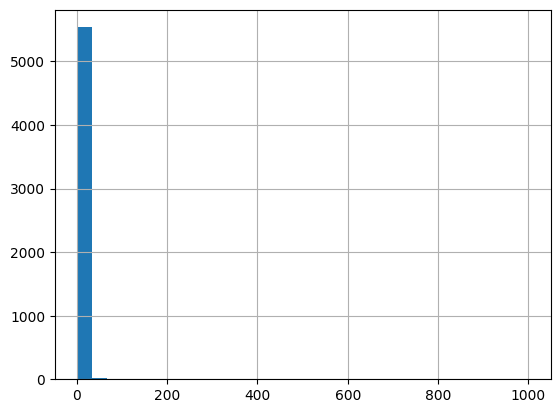

In [31]:
sales['quantity'].hist(bins=30)

<Axes: >

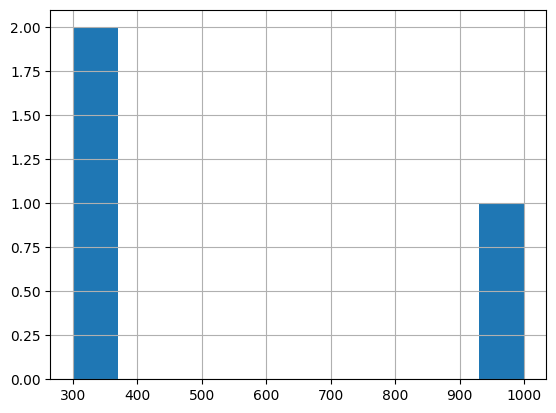

In [32]:
sales['quantity'].hist(range=(300,1000))

In [33]:
sales.query('quantity >= 300')

,date,customer_id,order_id,product,quantity,price,category,item_ttl_price
3372,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,decor,15300.0
3749,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,clothing care,49432.0
3816,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0,bath and toilet products,675000.0


In the line with index 3816 we see a purchase of 1000 plungers; we will consider this transaction an error and an outlier and delete it.

In [34]:
sales = sales.query('quantity <400')

Let's check the price of goods in one order.

<Axes: >

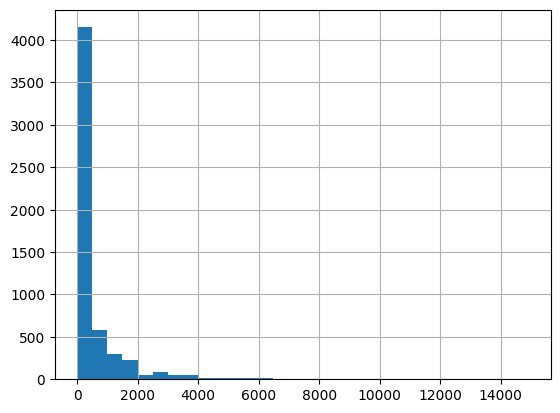

In [35]:
sales['price'].hist(bins=30)

<Axes: >

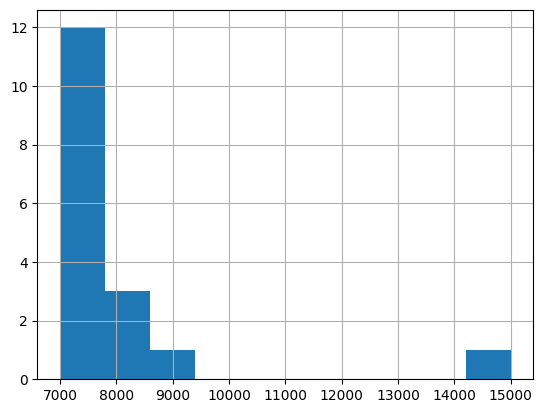

In [36]:
sales['price'].hist(range=(7000,15000))

In [37]:
sales.query('price >8000')

,date,customer_id,order_id,product,quantity,price,category,item_ttl_price
1694,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",1,8437.0,household products,8437.0
2295,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,"Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90",1,8737.0,household products,8737.0
2546,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0,household products,8077.0
4192,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0,clothing care,14917.0
5537,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0,household products,8077.0


In the line with index 4192 we see Outdoor dryer for the price - 14 917; we will consider this transaction an outlier and delete it.

In [38]:
sales = sales.query('price < 9000')

Let's check outliers in the number of orders.

<Axes: >

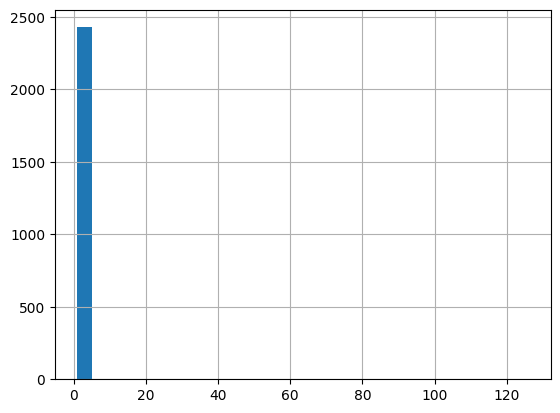

In [39]:
customers['orders_cnt'].hist(bins=30)

Most of the data is concentrated at the beginning of the axis, followed by a tail of outliers. Somewhere from 5 there is a reduction in values. Let’s zoom in to understand from which values is better to remove outliers.

<Axes: >

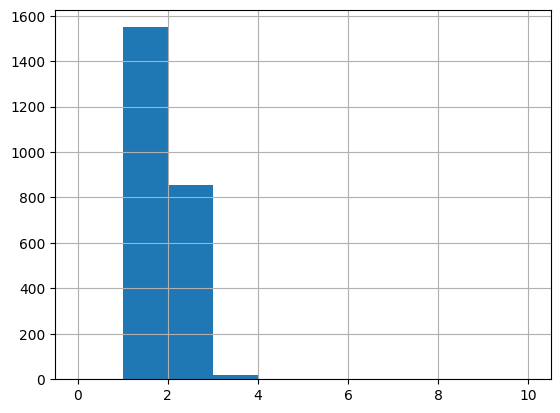

In [40]:
customers['orders_cnt'].hist(bins=10,range=(0,10))

After 3, there is a failure in the number of values.Let's look at the Top 10 by number of orders.

In [41]:
customers.sort_values(by='orders_cnt', ascending=False).head(10)

,customer_id,category_cnt,price_ttl,orders_cnt,product_cnt,items_ttl,avg_bill,avg_item_price
1904,c971fb21-d54c-4134-938f-16b62ee86d3b,8,159508.0,126,143,334,1265.936508,477.568862
740,4d93d3f6-8b24-403b-a74b-f5173e40d7db,8,57278.0,35,45,309,1636.514286,185.365696
1096,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,4,21361.0,17,17,17,1256.529412,1256.529412
1738,b7b865ab-0735-407f-8d0c-31f74d2806cc,2,3779.0,7,18,68,539.857143,55.573529
17,0184f535-b60a-4914-a982-231e3f615206,1,5891.0,5,30,58,1178.200000,101.568966
697,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,3,41900.0,4,4,85,10475.000000,492.941176
2129,e0535076-6270-4df2-8621-cb06264a94fa,3,636.0,4,4,4,159.000000,159.000000
1809,bea7a833-2074-42db-bc49-4457abd3c930,1,4409.0,4,14,30,1102.250000,146.966667
624,41117d9d-94f7-4145-a8c9-cb6675ce7674,1,574.0,3,3,23,191.333333,24.956522
925,62952c5b-e5ef-4009-a2f9-1ebff401c514,1,1629.0,3,11,11,543.000000,148.090909


We have 3 clients (index 1904,740,1096) who placed orders much more often than others, one of them (index 1096) ordered only 1 product at the time.
These 3 people can have big affect on segmentation, so I think they should be removed from the data.


In [42]:
customers = customers.query('orders_cnt <= 7')

We will check outliers in order amount.

<Axes: >

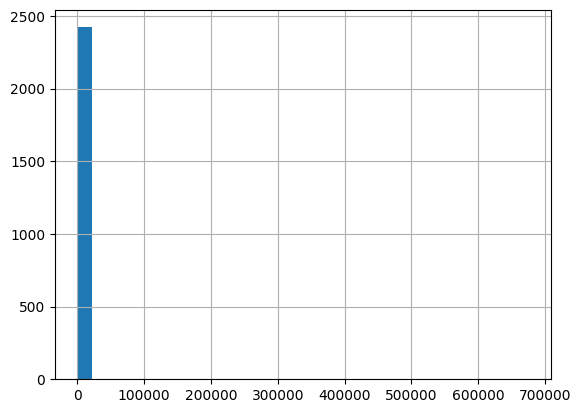

In [43]:
customers['price_ttl'].hist(bins=30)

<Axes: >

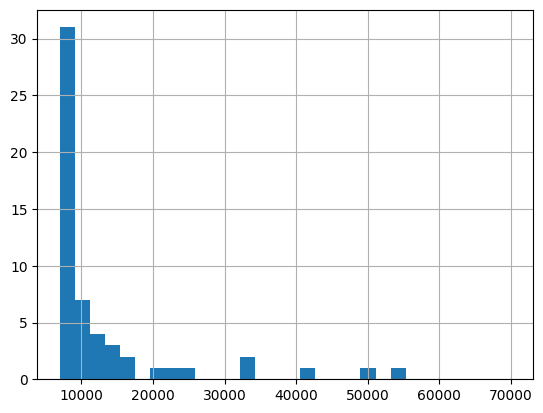

In [44]:
customers['price_ttl'].hist(range=(7000,70000), bins=30)

In [45]:
customers.sort_values(by='price_ttl', ascending=False).head(10)

,customer_id,category_cnt,price_ttl,orders_cnt,product_cnt,items_ttl,avg_bill,avg_item_price
467,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,1,675000.0,1,1,1000,675000.0,675.000000
836,58a4c3cc-504f-43ea-a74a-bae19e665552,1,53232.0,2,2,30,26616.0,1774.400000
199,146cd9bf-a95c-4afb-915b-5f6684b17444,1,49432.0,1,1,334,49432.0,148.000000
697,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,3,41900.0,4,4,85,10475.0,492.941176
1355,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,1,33680.0,1,6,101,33680.0,333.465347
989,6987e6d6-a63a-4ce2-a2d0-f424092d235e,1,32718.0,1,1,57,32718.0,574.000000
267,1b2764ad-9151-4051-a46a-9b01b62e6335,1,24370.0,1,1,5,24370.0,4874.000000
1501,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,5,22056.0,1,21,47,22056.0,469.276596
1390,940c175f-ea87-44e0-9e16-0a3d0a9abecd,1,20232.0,2,2,18,10116.0,1124.000000
2300,f279d50f-a508-40b4-bde5-5cb4a1be3ad0,2,16557.0,2,2,3,8278.5,5519.000000


The amount of orders also has a long tail of outliers.  
After viewing the top 10 clients by orders, I decided that we can delete data where the check amount is greater than 20 000.

In [46]:
customers = customers.query('price_ttl < 20000')
customers.describe()

,category_cnt,price_ttl,orders_cnt,product_cnt,items_ttl,avg_bill,avg_item_price
count,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000
mean,1.282645,1417.901825,1.375620,2.202893,4.998347,1091.379139,707.610960
std,0.478850,1714.960558,0.522958,3.184513,13.841959,1376.914849,1023.464816
min,1.000000,15.000000,1.000000,1.000000,1.000000,15.000000,14.000000
25%,1.000000,389.000000,1.000000,1.000000,1.000000,300.000000,134.000000
50%,1.000000,831.500000,1.000000,1.000000,2.000000,645.250000,337.250000
75%,2.000000,1783.250000,2.000000,2.000000,3.000000,1324.875000,899.000000
max,5.000000,16557.000000,7.000000,51.000000,300.000000,16536.000000,14917.000000


We remove from the original dataframe customers who were removed as outliers above.

In [47]:
sales_ = pd.merge(sales, customers[['customer_id']], on='customer_id', how='inner')
sales_.head()

,date,customer_id,order_id,product,quantity,price,category,item_ttl_price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,plants and seedlings,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,plants and seedlings,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,plants and seedlings,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,plants and seedlings,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,plants and seedlings,112.0


During outlier processing, 248 values were removed, or 4.4% of the previous sample or 3.3% of the original sample.
During data preprocessing, 28.7% of the original data was removed.

### Merge bases ###
 without outliers and with extra columns calculations

In [48]:
sales_ = pd.merge(sales_, customers, on='customer_id', how='left')

In [49]:
sales_.head()

,date,customer_id,order_id,product,quantity,price,category,item_ttl_price,category_cnt,price_ttl,orders_cnt,product_cnt,items_ttl,avg_bill,avg_item_price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,plants and seedlings,142.0,1,1037.0,1,7,7,1037.0,148.142857
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,plants and seedlings,194.0,1,1037.0,1,7,7,1037.0,148.142857
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,plants and seedlings,112.0,1,1037.0,1,7,7,1037.0,148.142857
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,plants and seedlings,179.0,1,1037.0,1,7,7,1037.0,148.142857
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,plants and seedlings,112.0,1,1037.0,1,7,7,1037.0,148.142857


## Exploratory data analysis (EDA) ##

In this block we will look into the matters:  
- means and deviations for numerical variables
- distribution of purchases by month
- popular categories

### MAU, unique users by month

In [50]:
sales_['date'] = sales_['date'].dt.strftime("%Y-%m")

In [51]:
sales_.groupby('date')['customer_id'].count().reset_index()

,date,customer_id
0,2018-10,391
1,2018-11,389
2,2018-12,267
3,2019-01,177
4,2019-02,334
5,2019-03,406
6,2019-04,671
7,2019-05,731
8,2019-06,298
9,2019-07,312


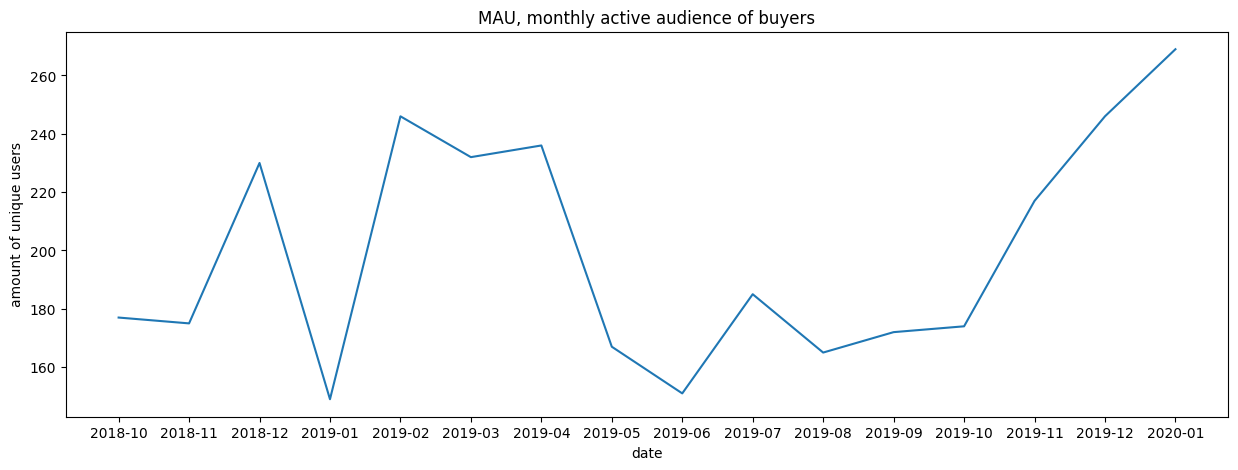

In [52]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(data=sales_.groupby('date')['customer_id'].nunique().reset_index(), x='date', y='customer_id')
ax.set(
    xlabel="date",
    ylabel="amount of unique users",
    title="MAU, monthly active audience of buyers"
)
plt.show();

For the period from October 2018 to January 2020, the following observations were made:
- A decrease in the active purchasing audience was noted in January 2019.
- A decline in the number of users occurred after April 2019.
- Since June 2019, an increasing trend has been observed, with a sharp rise in the active purchasing audience since October 2019.
- In January 2020, the maximum values for the number of customers were reached

### Sales by month ###

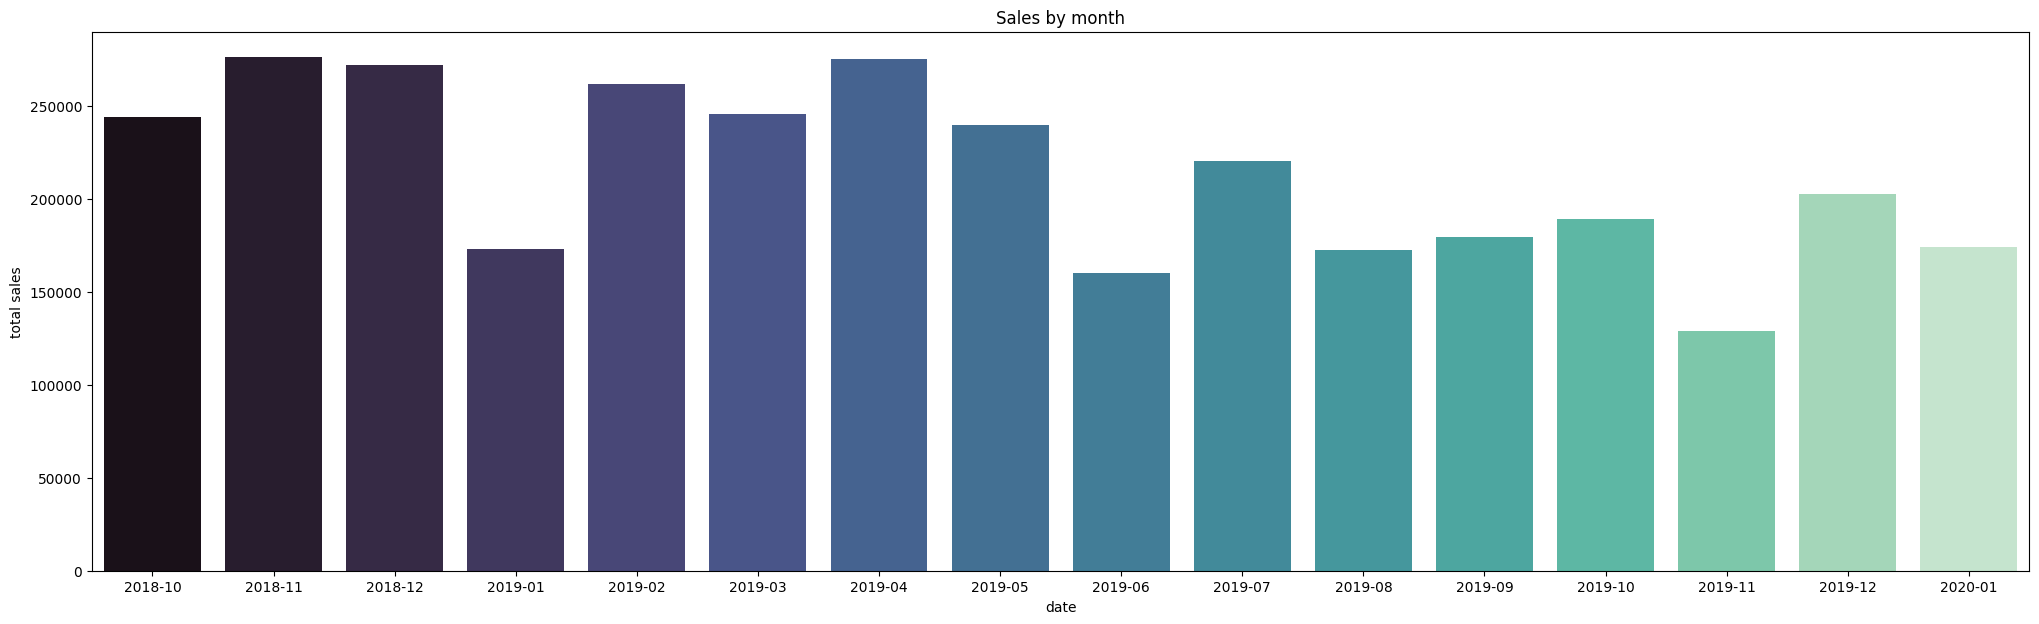

In [53]:
plt.figure(figsize=(25, 7))
ax = sns.barplot(data=sales_.groupby('date')['item_ttl_price'].sum().reset_index(), \
                 x='date', y='item_ttl_price', palette ='mako')
ax.set(
    xlabel="date",
    ylabel="total sales",
    title="Sales by month"
)
plt.show();

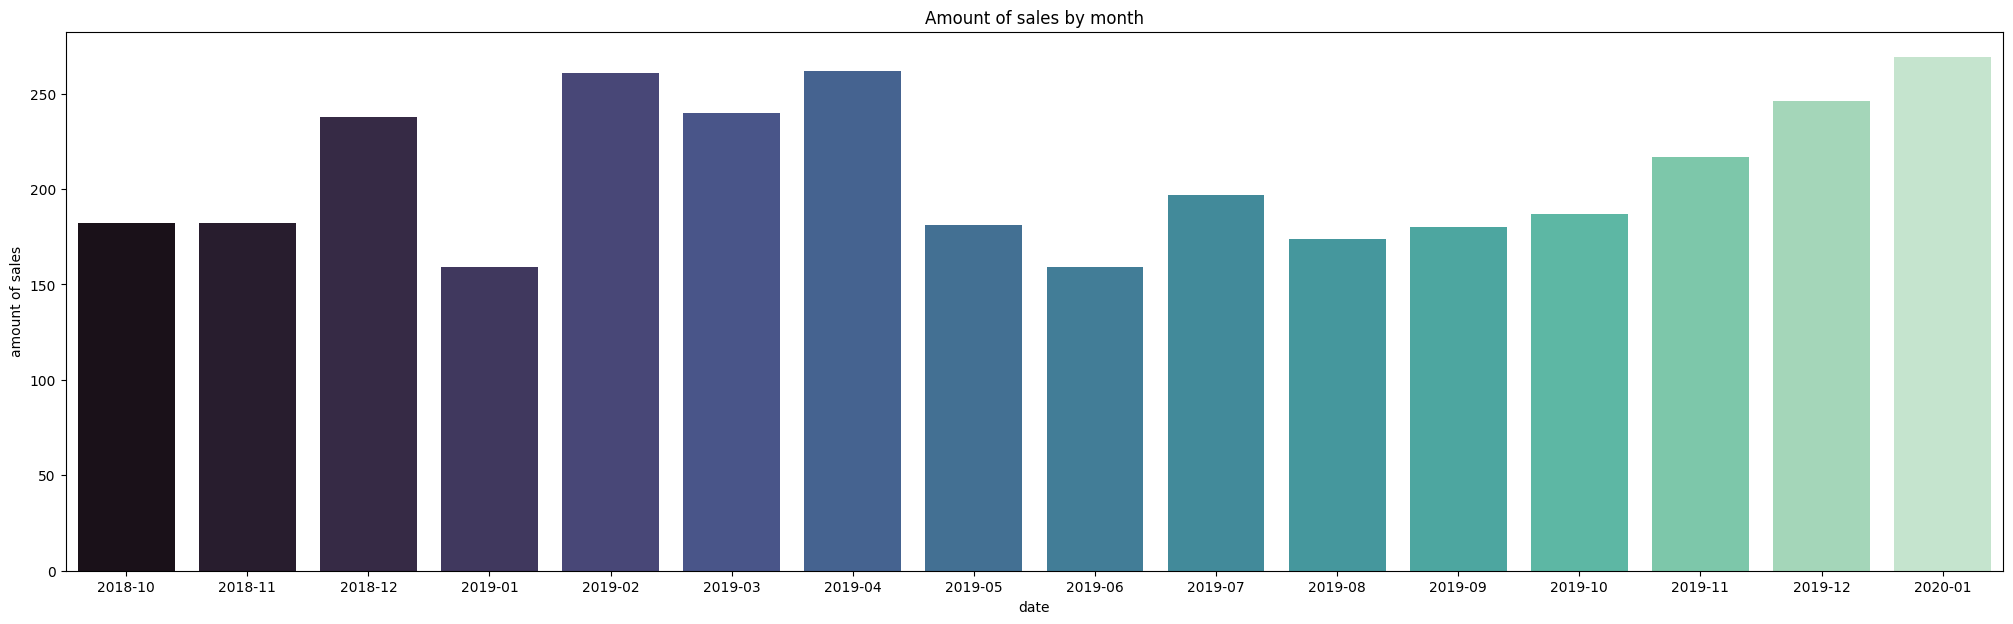

In [54]:
plt.figure(figsize=(25, 7))
ax = sns.barplot(data=sales_.groupby('date')['order_id'].nunique().reset_index(), x='date', y='order_id', palette ='mako')
ax.set(
    xlabel="date",
    ylabel="amount of sales",
    title="Amount of sales by month"
)
plt.show();

We observe that both orders and sales show a decline in January 2019, followed by growth in both indicators from February to April 2019.  
However, the correlation between the sales amount and the number of orders diminishes from August 2019. Despite the increase in the number of orders, we do not see a corresponding increase in the sales amount. On the contrary, we observe a significant drop in November 2019 and low figures in January 2020, despite having the highest number of orders for the entire period.

### Sales by category ###

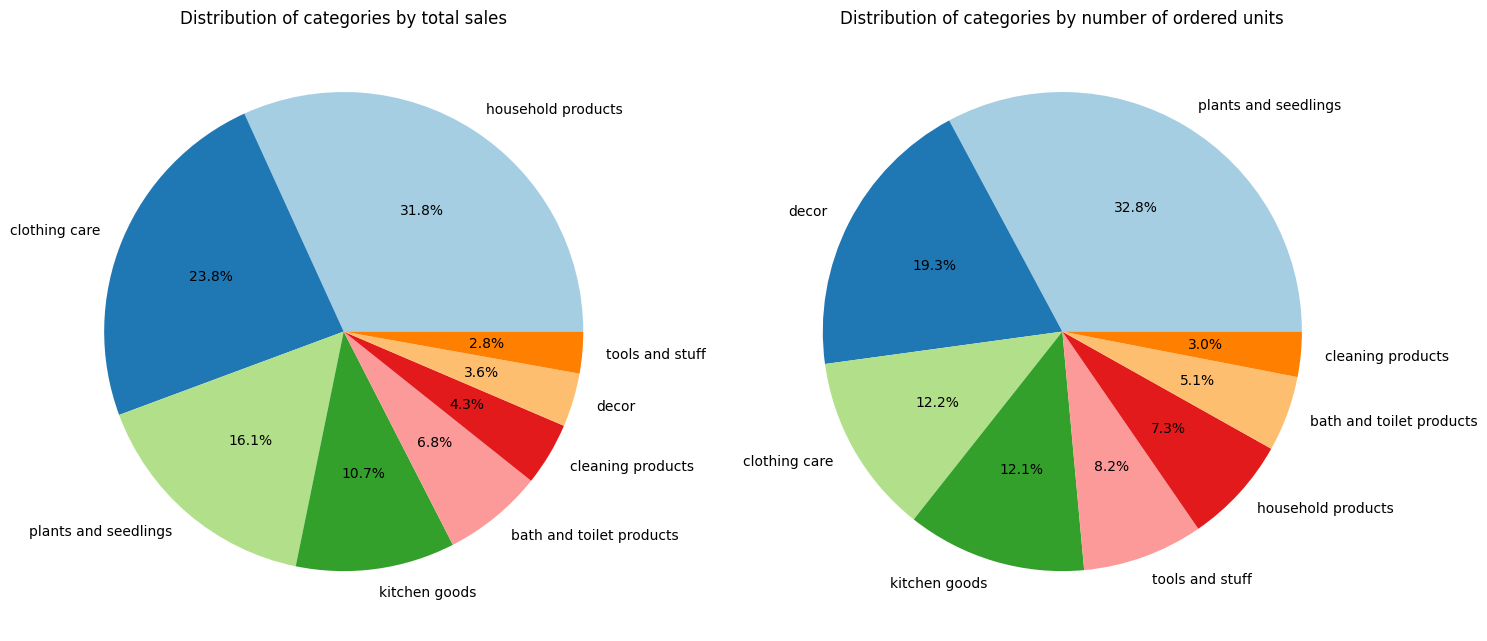

In [55]:
#group data by category
category = sales_.groupby('category')[['item_ttl_price', 'quantity']].sum().\
                                                        reset_index().sort_values(by='item_ttl_price', ascending=False)
#draw pie charts
fig, axes = plt.subplots(1, 2, figsize=(17, 10))

#total sales
sizes = category['item_ttl_price']
ax1 = axes[0].pie(sizes, labels=category['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set(title="Distribution of categories by total sales")

#sort the data by quantity
category = category.sort_values(by='quantity', ascending=False)

sizes1 = category['quantity']
ax2 = axes[1].pie(sizes1, labels=category['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1].set(title="Distribution of categories by number of ordered units")
plt.show();

The most profitable category is Household products, accounting for more than 31.8% of all sales.  
The category with the highest number of items purchased is Plants and Seedlings. 32.8% of the total number of ordered items were from this category.    
Top 3 categories by sales amount:  
1.Household products  
2.Clothing Care  
3.Plants and Seedlings  

Top 3 categories by number of ordered items:  
1.Plants and Seedlings  
2.Decor  
3.Clothing Care  

In [56]:
category_y=sales_.groupby(['date','category'])['item_ttl_price'].sum().reset_index()

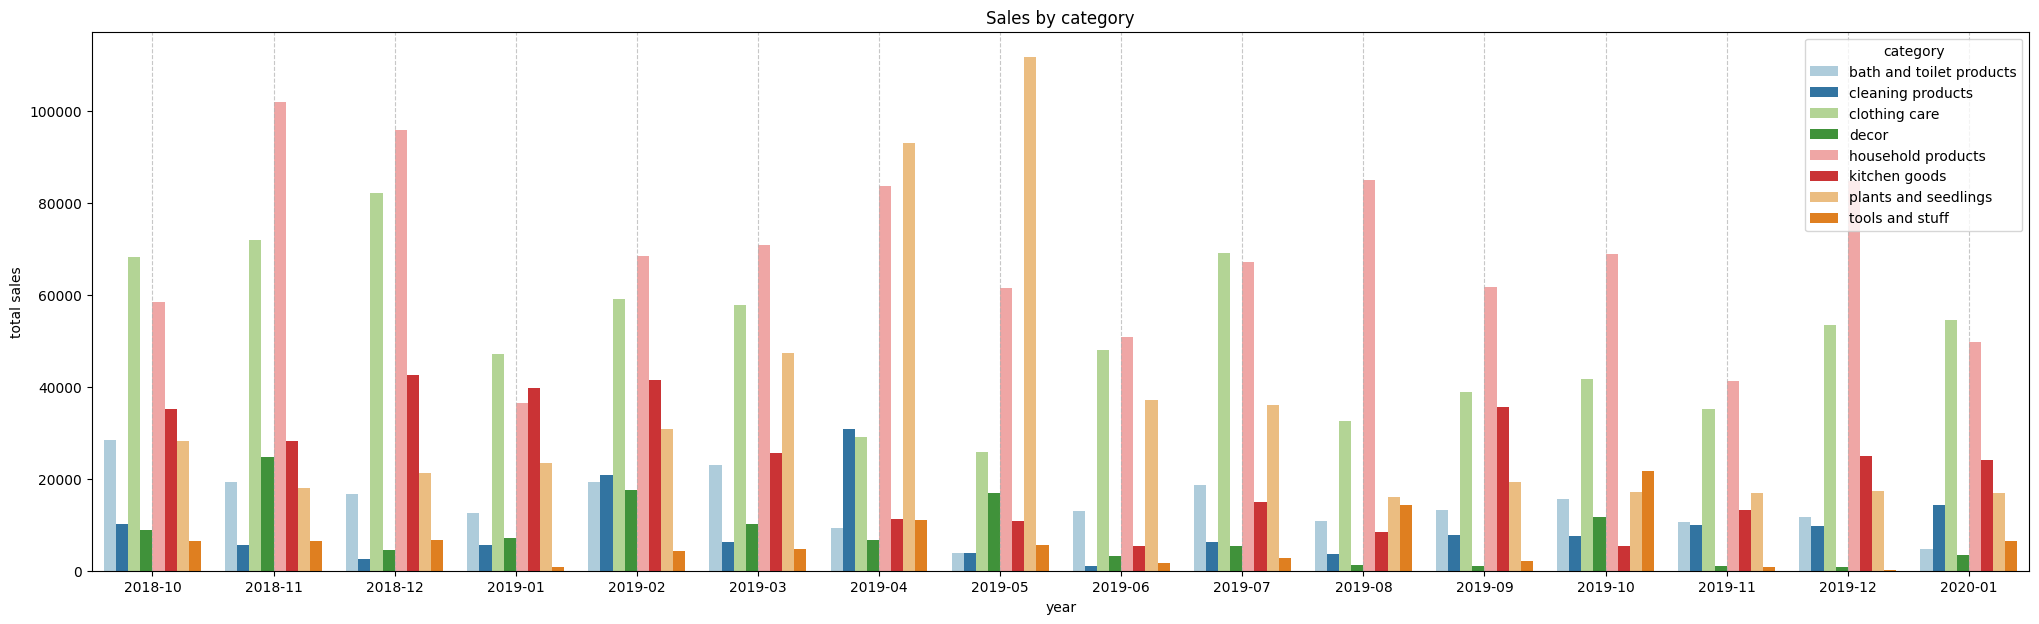

In [57]:
plt.figure(figsize=(25, 7))
ax = sns.barplot(data=category_y, x='date', y='item_ttl_price', hue='category', palette ='Paired', ci=None)
ax.set(
    xlabel="year",
    ylabel="total sales",
    title="Sales by category"
)
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.show();

In the breakdown by months, we can observe seasonality in the categories of Plants and Seedlings and Kitchen Goods.  
Plants and Seedlings become popular in April-May, after which their sales sharply decline.  
On the contrary, sales of Kitchen Goods decrease in spring and summer, with a growth observed towards December-January.  

### Averages and variances in data ###

In [58]:
sales_[['quantity','price']].describe()

,quantity,price
count,5330.000000,5330.000000
mean,2.269231,510.847483
std,8.418080,942.216522
min,1.000000,9.000000
25%,1.000000,90.000000
50%,1.000000,150.000000
75%,1.000000,487.000000
max,300.000000,8737.000000


In [59]:
customers.describe()

,category_cnt,price_ttl,orders_cnt,product_cnt,items_ttl,avg_bill,avg_item_price
count,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000
mean,1.282645,1417.901825,1.375620,2.202893,4.998347,1091.379139,707.610960
std,0.478850,1714.960558,0.522958,3.184513,13.841959,1376.914849,1023.464816
min,1.000000,15.000000,1.000000,1.000000,1.000000,15.000000,14.000000
25%,1.000000,389.000000,1.000000,1.000000,1.000000,300.000000,134.000000
50%,1.000000,831.500000,1.000000,1.000000,2.000000,645.250000,337.250000
75%,2.000000,1783.250000,2.000000,2.000000,3.000000,1324.875000,899.000000
max,5.000000,16557.000000,7.000000,51.000000,300.000000,16536.000000,14917.000000


* On average (median value), one item is ordered per transaction.
* The median price of one item is 134 rubles. The cheapest item cost 14 rubles, while the most expensive one was priced at 14 917 rubles.
* The median total spent by one customer is 831 rubles.
* Also, on average (median value), one customer made one purchase.
* The average bill is 1091 rubles, with the median value at 645 rubles.

## Segmentation ##

### Dataframe preparation ###

We prepare the dataframe to contain the following columns:
- number of purchases - orders_cnt
- amount of purchases - price_ttl
- average bill - avg_bill
- average number of types of goods per receipt - avg_product_cnt
- average number of product units per receipt -avg_items_cnt
- average price per unit of goods in the receipt - avg_item_price
- average number of categories in a receipt - avg_category

In [60]:
#calculation extra columns
customers.loc[:, 'avg_product_cnt'] = customers['product_cnt'] / customers['orders_cnt']
customers.loc[:, 'avg_category'] = customers['category_cnt'] / customers['orders_cnt']
customers.loc[:, 'avg_items_cnt'] = customers['items_ttl'] / customers['orders_cnt']

In [61]:
#drop columns, that we don't need
customers = customers.drop(['category_cnt','product_cnt','items_ttl'], axis = 1)

In [62]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2420 entries, 0 to 2431
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      2420 non-null   object 
 1   price_ttl        2420 non-null   float64
 2   orders_cnt       2420 non-null   int64  
 3   avg_bill         2420 non-null   float64
 4   avg_item_price   2420 non-null   float64
 5   avg_product_cnt  2420 non-null   float64
 6   avg_category     2420 non-null   float64
 7   avg_items_cnt    2420 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 170.2+ KB


### Determining the number of clusters ###

In [63]:
X = customers.drop('customer_id', axis = 1)

sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

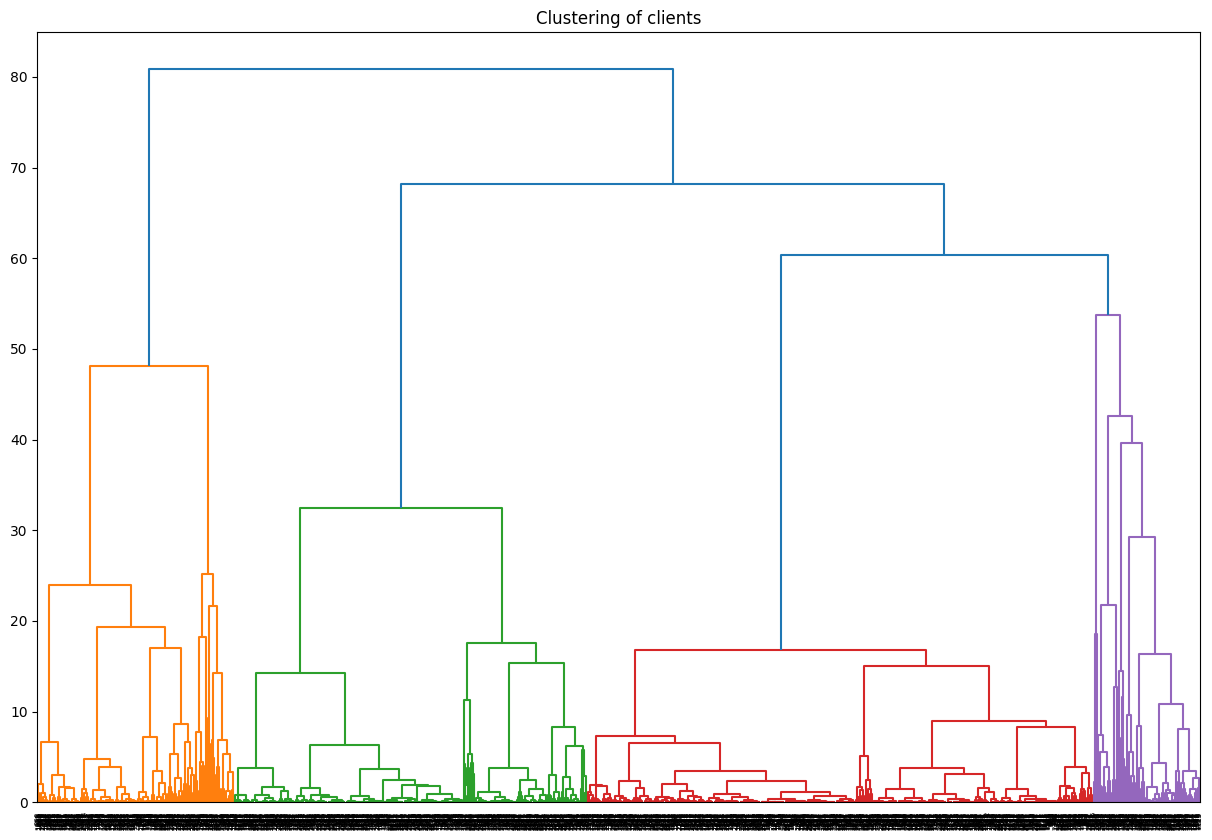

In [64]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Clustering of clients')
plt.show()

From the dendrogram we see that 4 clusters stand out.

### K-means segmentation ###

In [65]:
km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(X_sc)

In [66]:
customers['cluster'] = labels

In [67]:
customers.groupby('cluster')['customer_id'].count()

cluster
0      68
1     804
2    1343
3     205
Name: customer_id, dtype: int64

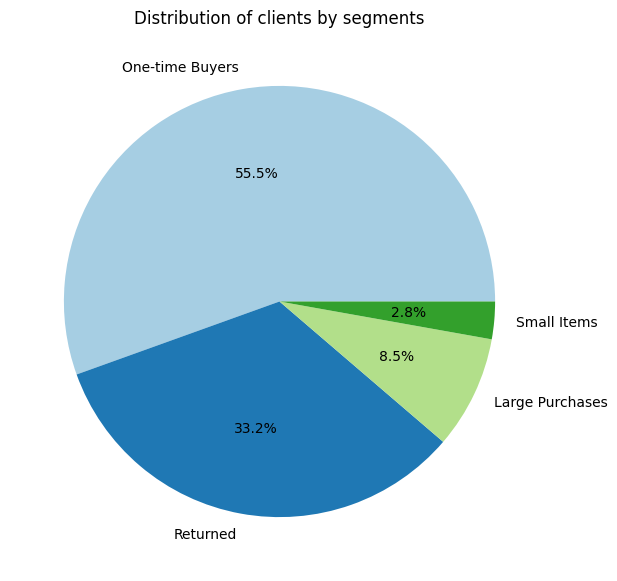

In [81]:
cl = customers.groupby('cluster')['customer_id'].count().reset_index().sort_values(by='customer_id', ascending=False)
cl['cluster'] = cl['cluster'].replace({0: 'Small Items', 1: 'Returned', 2: 'One-time Buyers', 3: 'Large Purchases'})
plt.figure(figsize=(7, 7))
plt.pie(x=cl['customer_id'], labels=cl['cluster'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Distribution of clients by segments')
plt.show();

In [69]:
cluster_features = customers.groupby('cluster').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,cluster,price_ttl,orders_cnt,avg_bill,avg_item_price,avg_product_cnt,avg_category,avg_items_cnt
0,0,3003.03,1.01,2966.22,131.19,12.34,1.71,44.54
1,1,1327.11,2.04,650.99,581.58,1.16,0.84,1.57
2,2,788.07,1.00,788.07,439.62,1.66,1.02,4.18
3,3,5374.35,1.36,4183.71,3148.73,1.08,0.96,3.19


**Cluster 1: Buys a Lot of Small Items**
* Has the lowest average unit price per product in the transaction - 131.2 rubles.
* On average, these customers have the most different item names in their * transactions - 12.4.
* They also have the most categories in a transaction.
* In this segment, there are an average of 44.5 product units per transaction.  

**Cluster 2: Returning Customers**
* On average, made 2 purchases in the store.
* They have the lowest "variety" of categories when making a purchase.
* The fewest items in a transaction, averaging 1.2.
* The lowest average order value - 651 rubles.

**Cluster 3: One-time Buyers**  
* On average, spent 788.1 rubles in the store.
* Made only 1 purchase.
* Average of 4.2 items per transaction.
* Average unit price of a product is 439.6 rubles.  

**Cluster 4: Large Purchases**  
* Spent more in the store than other customers, averaging 5374.4 rubles.
* Also, they have the highest average order value: 4183.7.
* The average unit price of a product is also the highest in this cluster - 3148.7.  








### Testing hypotheses ###

#### Hypothesis 1. Average bill between clusters are not equal. ####

  - H0 - There are no differences between average checks in segments
  - H1 - There are differences between average checks in segments

Since our distributions in the samples are far from normal, there are many outliers, and the sample sizes vary greatly, it is better to use the Mann-Whitney test.

To avoid a Type I error, where we obtain false positive results due to multiple testing, we can use the Bonferroni correction. Under this correction, we divide alpha by the number of tests conducted. In our case, with 4 clusters, this is 6 tests.


In [70]:
alpha = 0.05 / 6 #with Bonferroni correction, divide by the number of tests
unique_clusters = customers['cluster'].unique()

#comparing pairs of clusters
for cluster1, cluster2 in itertools.combinations(unique_clusters, 2):
    results = st.mannwhitneyu(customers[customers['cluster']==cluster1]['avg_bill'].dropna(),
                           customers[customers['cluster']==cluster2]['avg_bill'].dropna())

    #displaying test results
    print(f'Segment comparison {cluster1} и {cluster2}:')
    print(f'p-value: {results.pvalue}')

    #checking p-value
    if results.pvalue < alpha:
        print('Rejecting the null hypothesis')
    else:
        print("Don't reject the null hypothesis")

#display the average values of the segmentа
    print(f'Average check of the segment {cluster1}:', customers[customers['cluster']==cluster1]['avg_bill'].mean().round(1))
    print(f'Average check of the segment {cluster2}:',customers[customers['cluster']==cluster2]['avg_bill'].mean().round(1),'\n')

Segment comparison 2 и 3:
p-value: 3.41041543449723e-113
Rejecting the null hypothesis
Average check of the segment 2: 788.1
Average check of the segment 3: 4183.7 

Segment comparison 2 и 1:
p-value: 0.000506287200304078
Rejecting the null hypothesis
Average check of the segment 2: 788.1
Average check of the segment 1: 651.0 

Segment comparison 2 и 0:
p-value: 2.1292357611437532e-29
Rejecting the null hypothesis
Average check of the segment 2: 788.1
Average check of the segment 0: 2966.2 

Segment comparison 3 и 1:
p-value: 2.434060414685579e-108
Rejecting the null hypothesis
Average check of the segment 3: 4183.7
Average check of the segment 1: 651.0 

Segment comparison 3 и 0:
p-value: 3.2990570783988623e-09
Rejecting the null hypothesis
Average check of the segment 3: 4183.7
Average check of the segment 0: 2966.2 

Segment comparison 1 и 0:
p-value: 7.206256906801243e-33
Rejecting the null hypothesis
Average check of the segment 1: 651.0
Average check of the segment 0: 2966.2 



#### Hypothesis 2: Average unit price differs between segments. ####

  - H0 - No differences between average unit prices across segments
  - H1 - There are differences between average unit prices across segments

In [71]:
alpha = 0.05 / 6 ##with Bonferroni correction, divide by the number of tests
unique_clusters = customers['cluster'].unique()

#comparing pairs of clusters
for cluster1, cluster2 in itertools.combinations(unique_clusters, 2):
    results = st.mannwhitneyu(customers[customers['cluster']==cluster1]['avg_item_price'].dropna(),
                           customers[customers['cluster']==cluster2]['avg_item_price'].dropna())

    #displaying test results
    print(f'Segment comparison {cluster1} и {cluster2}:')
    print(f'p-value: {results.pvalue}')

    #Check p-value
    if results.pvalue < alpha:
        print('Rejecting the null hypothesis')
    else:
        print("Don't reject the null hypothesis")

 #display the average values of the segmentа
    print(f'Average unit price of the segment {cluster1}:', \
          customers[customers['cluster']==cluster1]['avg_item_price'].mean().round(1))
    print(f'Average unit price of the segment {cluster2}:',\
          customers[customers['cluster']==cluster2]['avg_item_price'].mean().round(1),'\n')

Segment comparison 2 и 3:
p-value: 9.297822420590147e-100
Rejecting the null hypothesis
Average unit price of the segment 2: 439.6
Average unit price of the segment 3: 3148.7 

Segment comparison 2 и 1:
p-value: 3.8313622174633963e-22
Rejecting the null hypothesis
Average unit price of the segment 2: 439.6
Average unit price of the segment 1: 581.6 

Segment comparison 2 и 0:
p-value: 1.6935030099861176e-10
Rejecting the null hypothesis
Average unit price of the segment 2: 439.6
Average unit price of the segment 0: 131.2 

Segment comparison 3 и 1:
p-value: 1.3245008931611662e-85
Rejecting the null hypothesis
Average unit price of the segment 3: 3148.7
Average unit price of the segment 1: 581.6 

Segment comparison 3 и 0:
p-value: 6.795305277816191e-34
Rejecting the null hypothesis
Average unit price of the segment 3: 3148.7
Average unit price of the segment 0: 131.2 

Segment comparison 1 и 0:
p-value: 3.888461893745719e-23
Rejecting the null hypothesis
Average unit price of the segme

During the hypothesis testing, both null hypotheses about the equality of means between segments were rejected.  
Therefore, the values between clusters differ significantly, and we can use the resulting segments for further analysis.

### Segments description ###

We separate clients from each segment into separate dataframes and look at their main characteristics.

* Cluster 1: Buys a Lot of Small Items
* Cluster 2: Returning Customers
* Cluster 3: One-time Buyers
* Cluster 4: Large Purchases

Let's consider the following indicators by cluster:

- general characteristics: number of users, average bill, total sales, unit price, average number of products and number of purchases
- seasonality of purchases
- popular categories and their distribution

In [72]:
#add additional data and information about the segment to the original dataframe
sales_=sales_.merge(customers[['customer_id','avg_product_cnt','avg_items_cnt','avg_category','cluster']],\
                    on='customer_id', how='left' )

In [73]:
sales_.head()

,date,customer_id,order_id,product,quantity,price,category,item_ttl_price,category_cnt,price_ttl,orders_cnt,product_cnt,items_ttl,avg_bill,avg_item_price,avg_product_cnt,avg_items_cnt,avg_category,cluster
0,2018-10,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,plants and seedlings,142.0,1,1037.0,1,7,7,1037.0,148.142857,7.0,7.0,1.0,2
1,2018-10,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,plants and seedlings,194.0,1,1037.0,1,7,7,1037.0,148.142857,7.0,7.0,1.0,2
2,2018-10,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,plants and seedlings,112.0,1,1037.0,1,7,7,1037.0,148.142857,7.0,7.0,1.0,2
3,2018-10,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,plants and seedlings,179.0,1,1037.0,1,7,7,1037.0,148.142857,7.0,7.0,1.0,2
4,2018-10,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,plants and seedlings,112.0,1,1037.0,1,7,7,1037.0,148.142857,7.0,7.0,1.0,2


In [74]:
#divide the dataframe into 3 segments
seg1 = sales_.query('cluster == 0')
seg2 = sales_.query('cluster == 1')
seg3 = sales_.query('cluster == 2')
seg4 = sales_.query('cluster == 3')

#### General visualizations ####

**Average values by segment.**

In [75]:
cluster_features = customers.groupby('cluster').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,cluster,price_ttl,orders_cnt,avg_bill,avg_item_price,avg_product_cnt,avg_category,avg_items_cnt
0,0,3003.03,1.01,2966.22,131.19,12.34,1.71,44.54
1,1,1327.11,2.04,650.99,581.58,1.16,0.84,1.57
2,2,788.07,1.00,788.07,439.62,1.66,1.02,4.18
3,3,5374.35,1.36,4183.71,3148.73,1.08,0.96,3.19


**Distribution of sales by segments.**

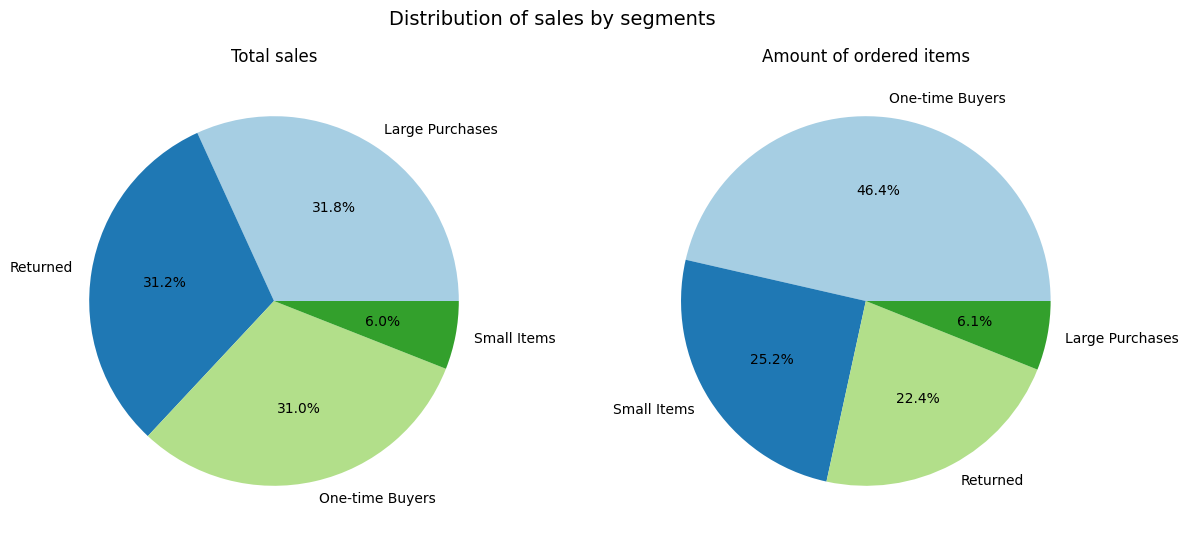

In [82]:
seg_sale=sales_.groupby('cluster')[['item_ttl_price','quantity']].sum().\
                                    reset_index().sort_values(by='item_ttl_price', ascending=False)
seg_sale['cluster'] = seg_sale['cluster'].replace({0: 'Small Items', 1: 'Returned', 2: 'One-time Buyers', 3: 'Large Purchases'})
#draw pei-charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribution of sales by segments', fontsize=14)

#total sales
sizes = seg_sale['item_ttl_price']
ax1 = axes[0].pie(sizes, labels=seg_sale['cluster'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set(title="Total sales")

#sort data by amount of items
seg_sale = seg_sale.sort_values(by='quantity', ascending=False)

sizes1 = seg_sale['quantity']
ax2 = axes[1].pie(sizes1, labels=seg_sale['cluster'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1].set(title="Amount of ordered items")
plt.show();

Segment 'Small Items' brings less money, then other segments, but it ranks second in terms of the number of items ordered.  
'Large Purchases' is the most profitable segment,customers from it buy it has the fewest amount of items.  
Clients from 'Returned' segment take 2nd place by share of sales and 3d place by amount of ordered units.

We can visualize **seasonality of purchases**.

In [77]:
season = sales_.groupby(['date','cluster'])[['item_ttl_price','quantity']].sum().reset_index()

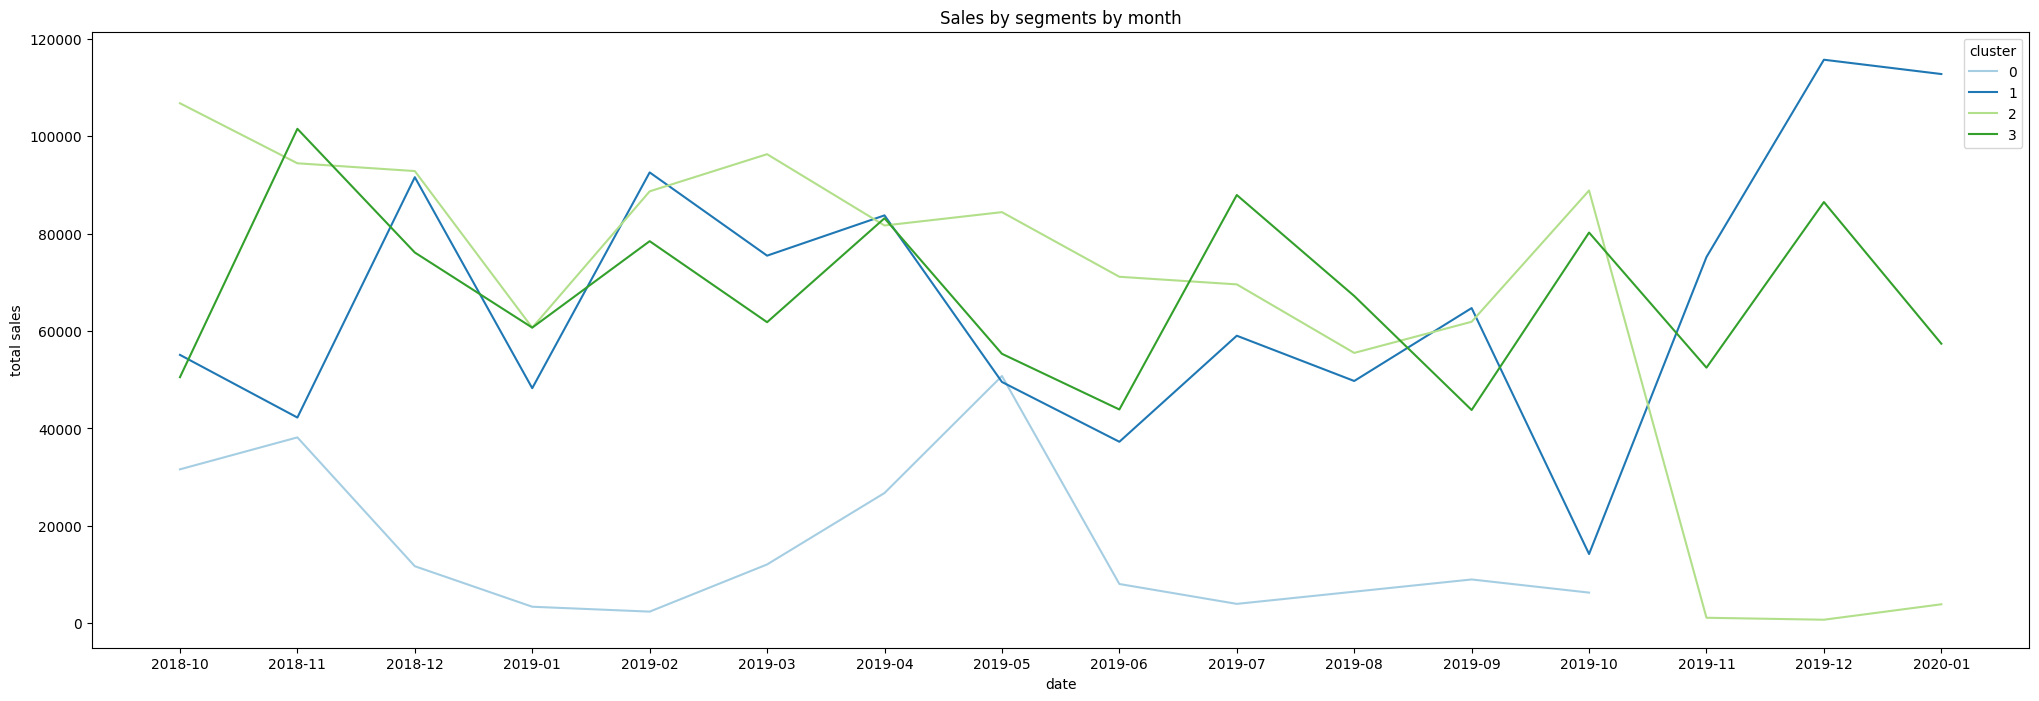

In [78]:
plt.figure(figsize=(25, 8))
ax = sns.lineplot(data=season, x='date', y='item_ttl_price', hue='cluster', palette ='Paired')
ax.set(
    xlabel="date",
    ylabel="total sales",
    title="Sales by segments by month"
)
plt.show();

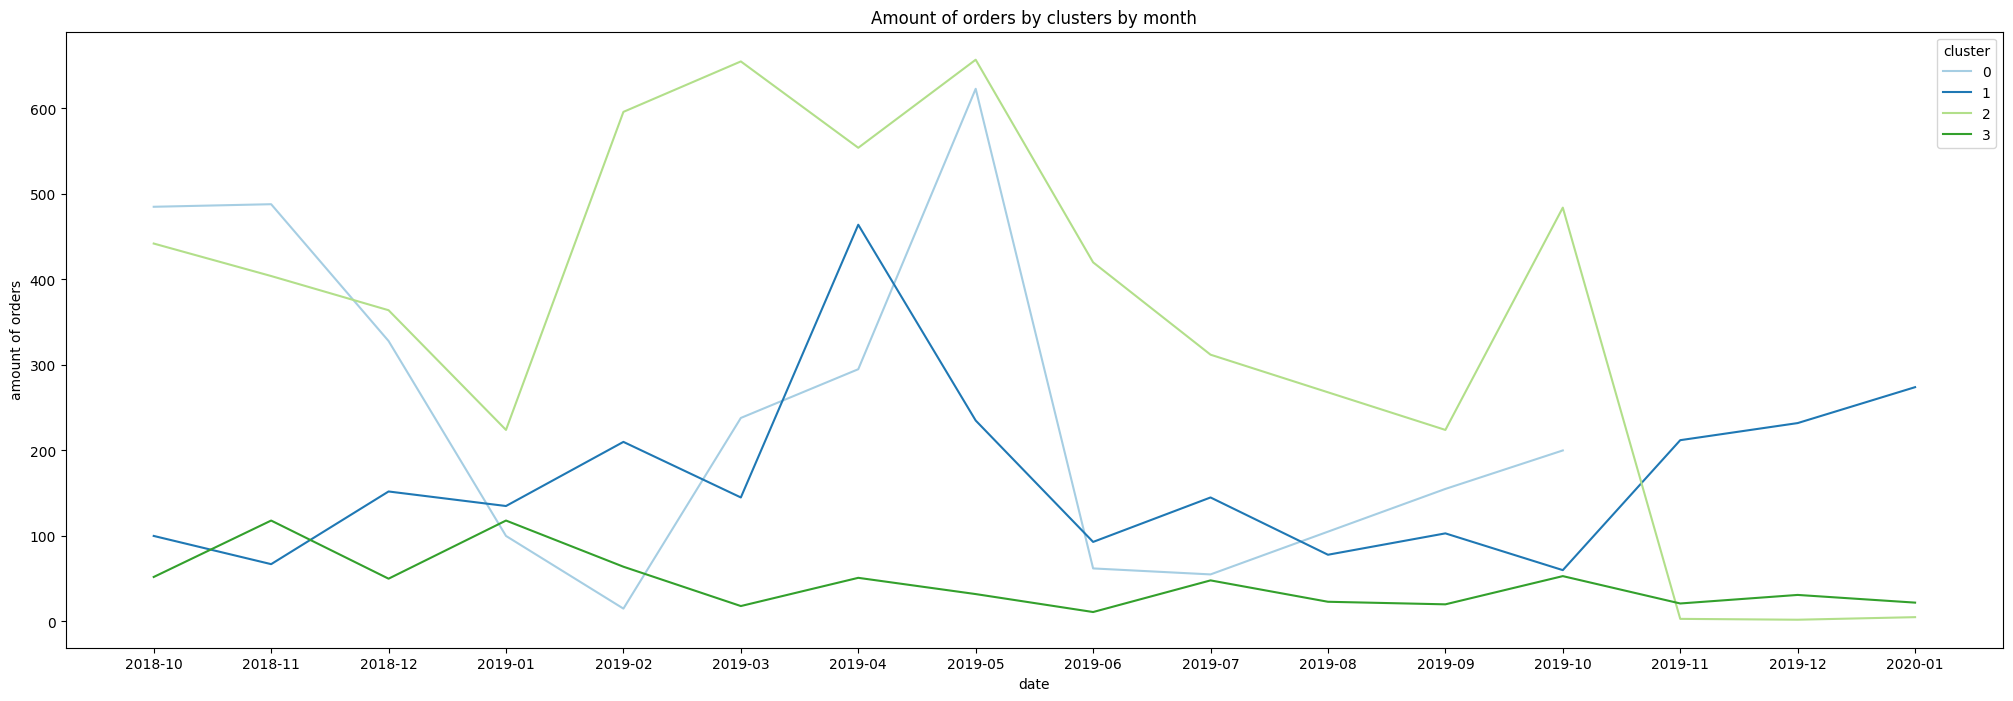

In [104]:
plt.figure(figsize=(25, 8))
ax = sns.lineplot(data=season, x='date', y='quantity', hue='cluster', palette ='Paired')
ax.set(
    xlabel="date",
    ylabel="amount of orders",
    title="Amount of orders by clusters by month"
)
plt.show();

There are no sales after october 2019 by segment 1.  
We can se sale decline after october 2019 by segment 3.  
For segment 2 is characterized by an increase in sales amount and the number of orders towards the end of the period.

Let's see which **categories of sales** lead in each segment.

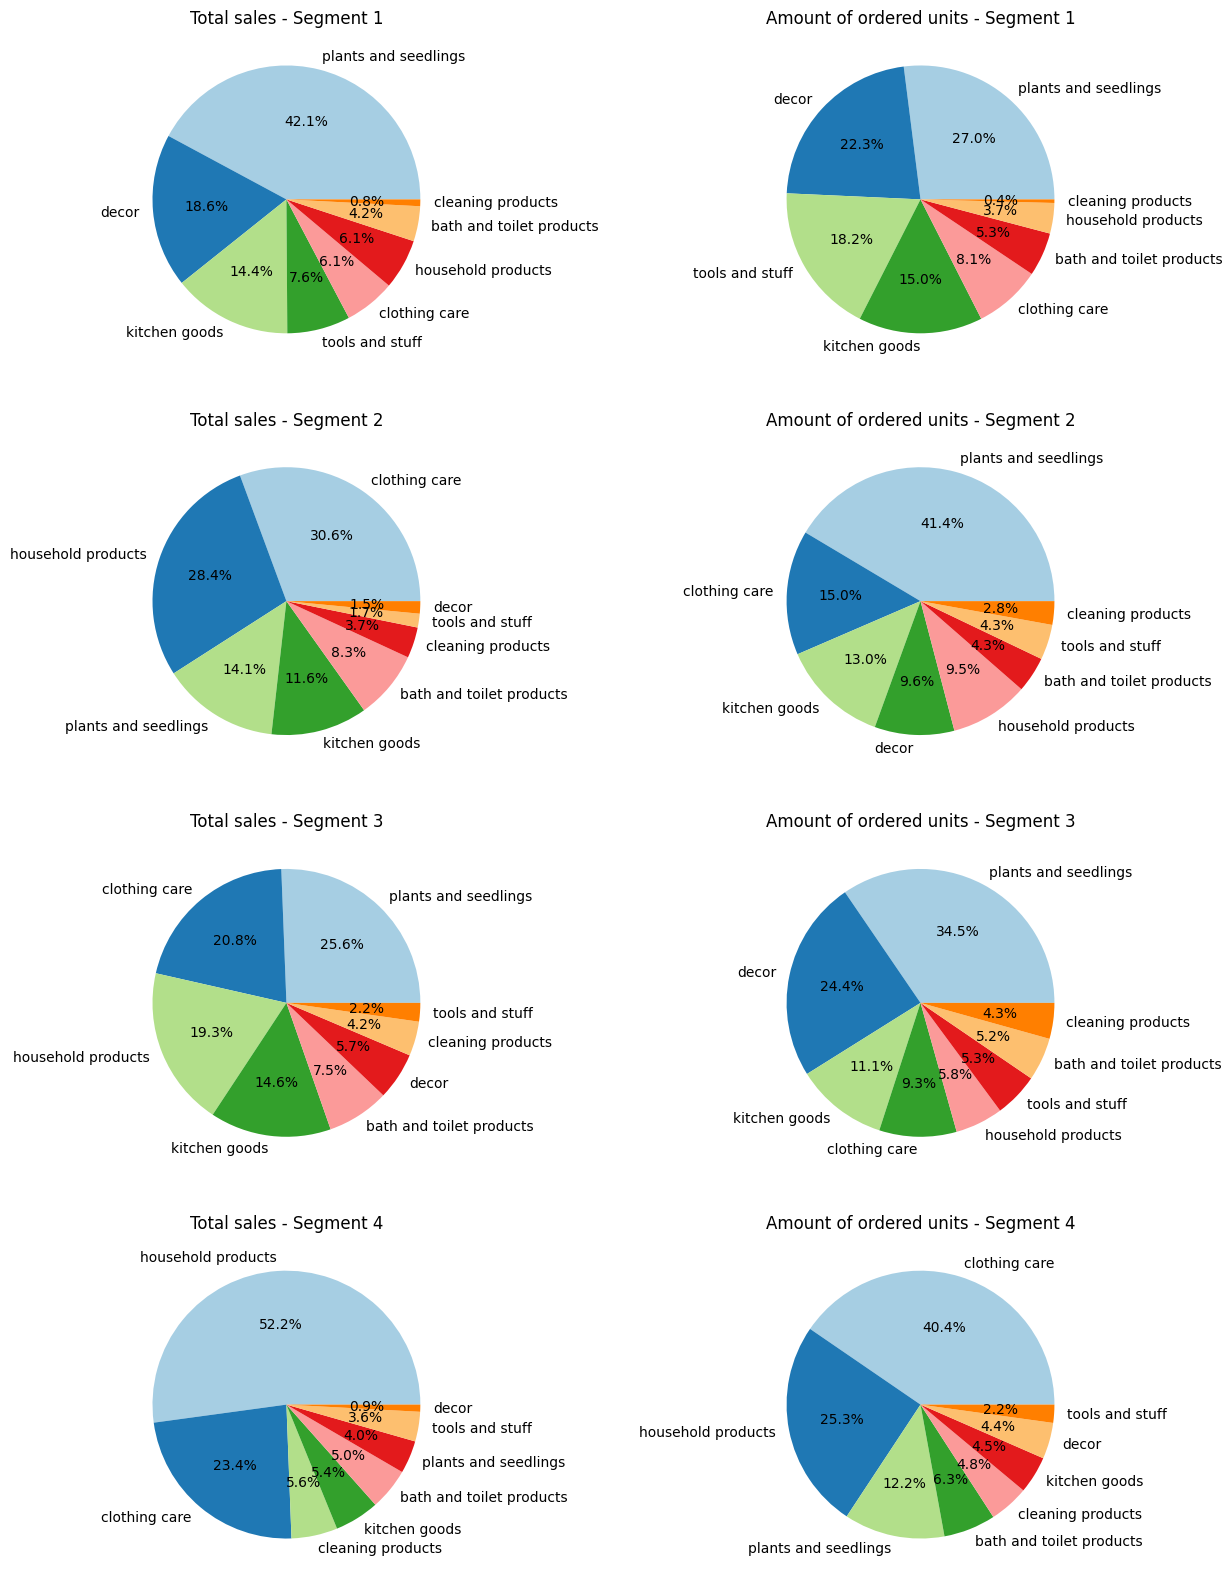

In [80]:
segments = [seg1, seg2, seg3, seg4]

fig, axes = plt.subplots(len(segments), 2, figsize=(15, 5 * len(segments)))

for i, segment in enumerate(segments):

    category_segment = segment.groupby('category')[['item_ttl_price', 'quantity']].sum().reset_index().\
    sort_values(by='item_ttl_price', ascending=False)

    # Total sales
    sizes_total_sales = category_segment['item_ttl_price']
    axes[i, 0].pie(sizes_total_sales, labels=category_segment['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    axes[i, 0].set(title=f"Total sales - Segment {i + 1}")

    # Amount of ordered units
    category_segment = category_segment.sort_values(by='quantity', ascending=False)
    sizes_quantity = category_segment['quantity']
    axes[i, 1].pie(sizes_quantity, labels=category_segment['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    axes[i, 1].set(title=f"Amount of ordered units - Segment {i + 1}")

plt.show()

#### Segment 1 "Small Items" ####

In [83]:
customers[['cluster']].query('cluster==0').count()

cluster    68
dtype: int64

In [84]:
customers.query('cluster==0').groupby('cluster').mean().reset_index()

,cluster,price_ttl,orders_cnt,avg_bill,avg_item_price,avg_product_cnt,avg_category,avg_items_cnt
0,0,3003.029412,1.014706,2966.220588,131.191102,12.338235,1.713235,44.544118


*This segment is characterized by customers who buy a lot of cheap items at once.*

There are 68 users in this segment.

**General characteristics:**

- Over the study period, they made only 1 purchase, rarely more.
- On average, these customers spend about 3 thousand in our store, with an average order value of 2966.2 rubles.
- This segment includes customers who purchase the cheapest items, with an average unit cost of 131.2 rubles.
- The segment is characterized by a large number of item names in a transaction (an average of 12.3 types of items).
- There is also a large number of items in a transaction - an average of 44.5 pieces.

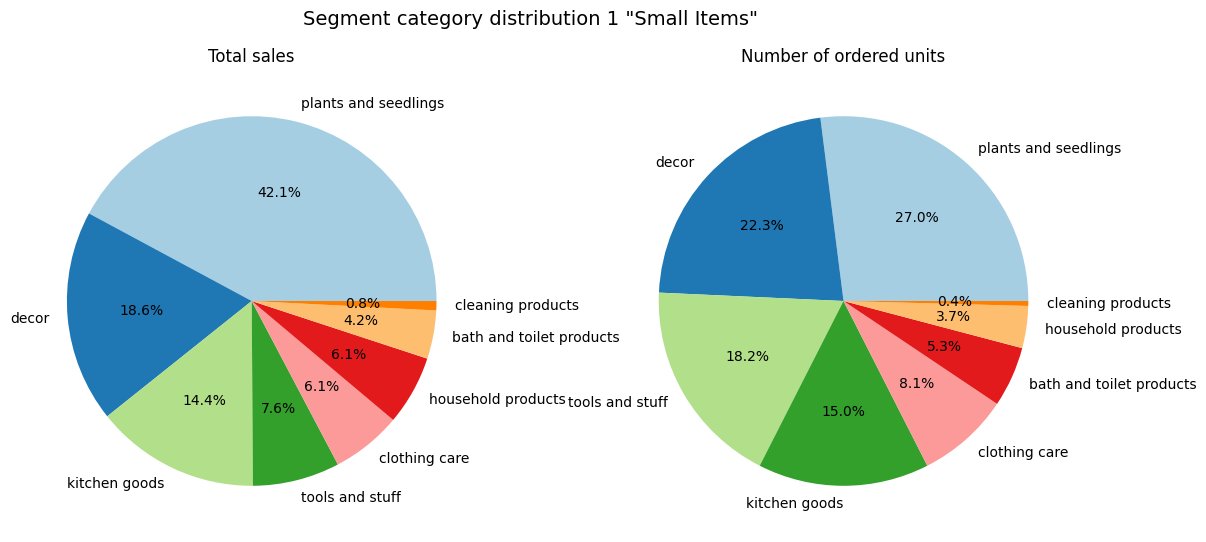

In [91]:
#group data by category
category_seg1 = seg1.groupby('category')[['item_ttl_price', 'quantity']].sum().\
                                                        reset_index().sort_values(by='item_ttl_price', ascending=False)
#draw pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Segment category distribution 1 "Small Items"', fontsize=14)

#total sales
sizes = category_seg1['item_ttl_price']
ax1 = axes[0].pie(sizes, labels=category_seg1['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set(title="Total sales")

#sort the data by pieces
category_seg1 = category_seg1.sort_values(by='quantity', ascending=False)

sizes1 = category_seg1['quantity']
ax2 = axes[1].pie(sizes1, labels=category_seg1['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1].set(title="Number of ordered units")
plt.show();

The most popular category is Plants and Seedlings. It accounts for 42.1% of total sales and 27% of the total number of items sold.

In second place is the Decor category, followed by Kitchen Goods in third place.

In [92]:
#visualization of category sales by month
fig = px.bar(seg1.groupby(['date','category'])['item_ttl_price'].sum().reset_index(), \
            x='date', y='item_ttl_price', color='category',
             color_discrete_sequence=px.colors.qualitative.Prism,
            template="plotly_white")
fig.update_layout(title='Segment 1 "Small Items" sales by month ',
    xaxis_title='date',
    yaxis_title='total sales',
                  width=1000,
                 height=350)
fig.show()

In [93]:
#visualization of the number of orders of categories by month
fig = px.bar(seg1.groupby(['date','category'])['quantity'].sum().reset_index(), \
            x='date', y='quantity', color='category',
             color_discrete_sequence=px.colors.qualitative.Prism,
            template="plotly_white")
fig.update_layout(title='Number of orders by month of segment 1 "Small Items"',
    xaxis_title='date',
    yaxis_title='number of orders',
                  width=1000,
                 height=350)
fig.show()

Sales in this segment show seasonality, with sales increasing from March to May. However, we can also note a growth in sales in October and November.

Based on the seasonality and consumption patterns, we can specify that this segment has its own holiday-garden specificity. Customers stock up for the beginning of the planting season or within the framework of traditional holidays, such as February 14th or March 8th.

#### Segment 2 "Returned"

In [87]:
customers[['cluster']].query('cluster==1').count()

cluster    804
dtype: int64

In [88]:
customers.query('cluster==1').groupby('cluster').mean().reset_index()

,cluster,price_ttl,orders_cnt,avg_bill,avg_item_price,avg_product_cnt,avg_category,avg_items_cnt
0,1,1327.109349,2.037313,650.991209,581.584066,1.1595,0.837047,1.568177


*This segment is characterized by customers who have made repeat purchases in our store. Most likely, these are returning customers making repeat similar purchases.*

There are 804 users in this segment.

**General characteristics:**

- On average, customers in this segment made 2 purchases.
- This segment has the lowest average bill, with a value of 581.6 rubles.
- The total amount spent is slightly above 1,000 rubles on average, specifically 1,327 rubles.
- Most often, there is only one type of item in the purchases of these customers.
- This segment also has the fewest number of items per transaction.

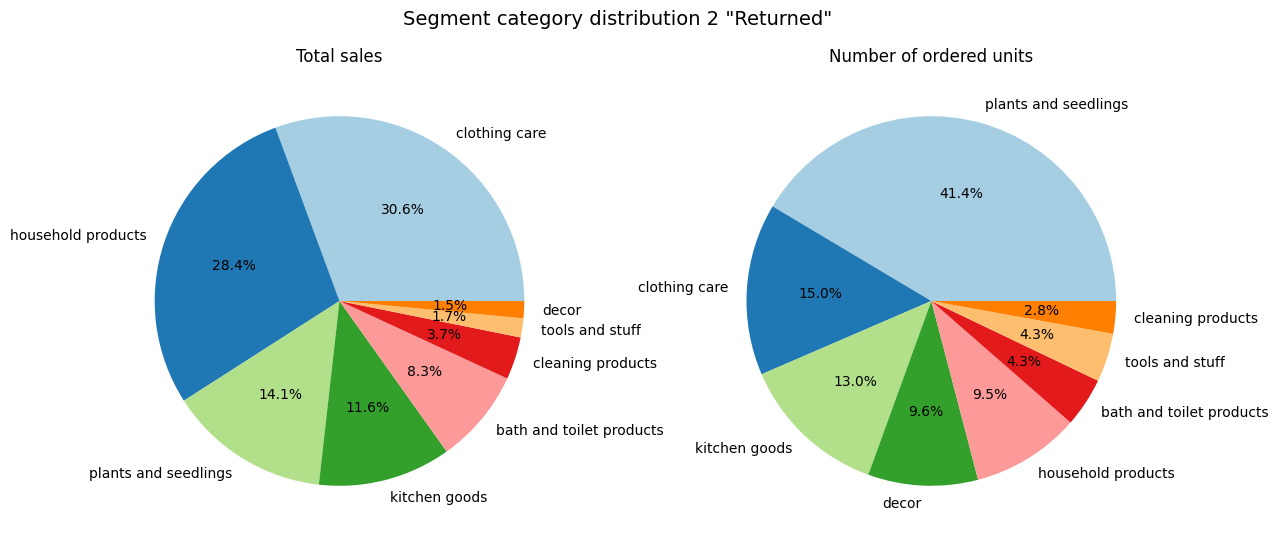

In [94]:
#group data by category
category_seg2 = seg2.groupby('category')[['item_ttl_price', 'quantity']].sum().\
                                                        reset_index().sort_values(by='item_ttl_price', ascending=False)
#draw pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Segment category distribution 2 "Returned"', fontsize=14)

#total sales
sizes = category_seg2['item_ttl_price']
ax1 = axes[0].pie(sizes, labels=category_seg2['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set(title="Total sales")

#sort the data by pieces
category_seg2 = category_seg2.sort_values(by='quantity', ascending=False)

sizes1 = category_seg2['quantity']
ax2 = axes[1].pie(sizes1, labels=category_seg2['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1].set(title="Number of ordered units")
plt.show();

In terms of the number of purchased items, the "Plants and Seedlings" category leads in the segment with 41.4%, followed by the "Clothing Care" and "Kitchen Goods" categories.

The most money spent in the segment was on the "Clothing Care" category, accounting for 30.6% of total sales, closely followed by "Home Goods" at 28.4%. "Seedlings and Plants" rank third in this regard.

In [95]:
#visualization of category sales by month
fig = px.bar(seg2.groupby(['date','category'])['item_ttl_price'].sum().reset_index(), \
            x='date', y='item_ttl_price', color='category',
             color_discrete_sequence=px.colors.qualitative.Prism,
            template="plotly_white")
fig.update_layout(title='Segment 2 "Returned" sales by month ',
    xaxis_title='date',
    yaxis_title='total sales',
                  width=1000,
                 height=350)
fig.show()

In [96]:
#visualization of the number of orders of categories by month
fig = px.bar(seg2.groupby(['date','category'])['quantity'].sum().reset_index(), \
            x='date', y='quantity', color='category',
             color_discrete_sequence=px.colors.qualitative.Prism,
            template="plotly_white")
fig.update_layout(title='Number of orders by month of segment 2 "Returned"',
    xaxis_title='date',
    yaxis_title='number of orders',
                  width=1000,
                 height=350)
fig.show()

Since the segment is characterized by repeat purchases and we observe an increase in sales towards the end of the period, it would be interesting to see if this is related to an activation of repeat purchases during this period.

In [97]:
#let's group the data by customers and look at the dates of the first and last purchase
mm_seg2 = seg2.groupby('customer_id')['date'].agg(['min','max']).reset_index()
#Let's see which months have the most repeat purchases
mm_seg2.query('min!=max')['max'].value_counts()

2020-01    245
2019-12    217
2019-11    195
2019-10      9
2019-04      9
2019-03      5
2019-05      4
2019-08      4
2019-01      3
2019-07      3
2019-06      2
2019-09      1
Name: max, dtype: int64

Based on the fact that the most recent purchases of customers in this segment fall within the last 3 months of our dataset, we can assume that such repeat activity may have been stimulated by some successful marketing actions. Therefore, in the sales graphs, we see growth both in the number of purchases and in monetary results precisely from November 2019 to January 2020.

Otherwise, there is no significant seasonal trend observed.

#### Segment 3 "One-time Buyers"

In [85]:
customers[['cluster']].query('cluster==2').count()

cluster    1343
dtype: int64

In [86]:
customers.query('cluster==2').groupby('cluster').mean().reset_index()

,cluster,price_ttl,orders_cnt,avg_bill,avg_item_price,avg_product_cnt,avg_category,avg_items_cnt
0,2,788.069993,1.0,788.069993,439.622916,1.658972,1.018615,4.180194


*Clients from this segment made only one purchase in our shop and in avarege spent the fewest amount of money*   

In this segment, there are 1343 users.

**General characteristics:**

- Over the study period, they made only 1 purchase.
- The average order value and average total spent are the lowest among the segments, at 788 rubles.
- The average unit price in this segment is 439.6 rubles.
- Customers on average purchase more than 1 type of item.
- The average number of items per transaction is 4.1.






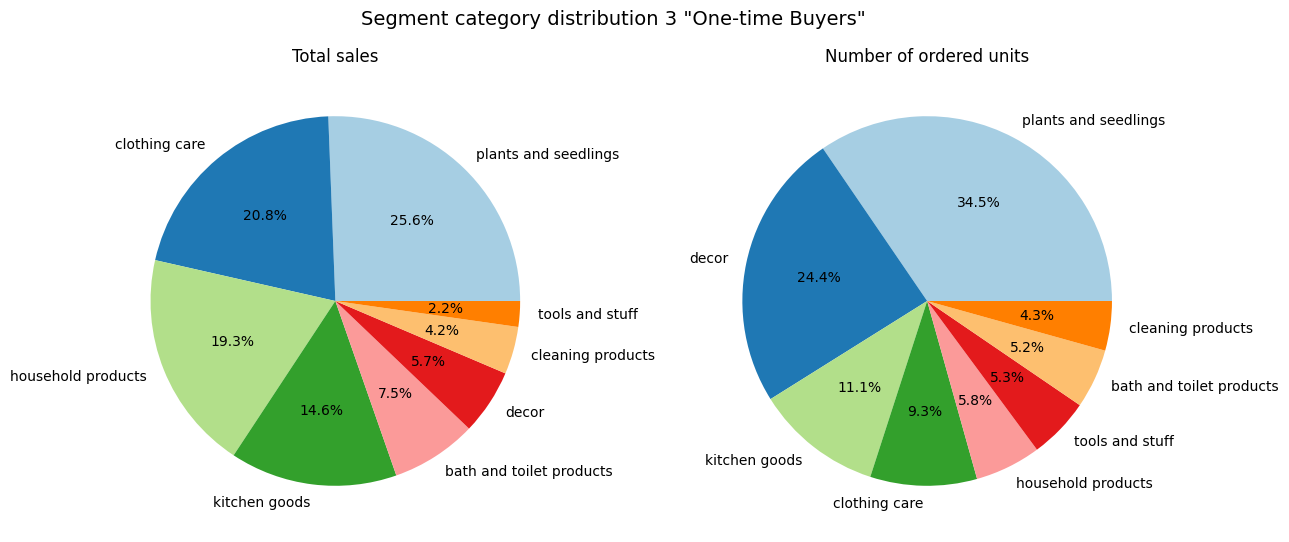

In [98]:
#group data by category
category_seg3 = seg3.groupby('category')[['item_ttl_price', 'quantity']].sum().\
                                                        reset_index().sort_values(by='item_ttl_price', ascending=False)
#draw pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Segment category distribution 3 "One-time Buyers"', fontsize=14)

#total sales
sizes = category_seg3['item_ttl_price']
ax1 = axes[0].pie(sizes, labels=category_seg3['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set(title="Total sales")

#sort the data by pieces
category_seg3 = category_seg3.sort_values(by='quantity', ascending=False)

sizes1 = category_seg3['quantity']
ax2 = axes[1].pie(sizes1, labels=category_seg3['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1].set(title="Number of ordered units")
plt.show();

The most popular category is Plants and Seedlings. Plants and Seedlings lead both in terms of the number of items sold and revenue. In terms of sales amount, it accounts for 25.6%, and for the number of items sold, it accounts for 34.5%.

In terms of expenditure, "Clothing Care" ranks second, followed by "Home Goods" in third place. When looking at the top 3 categories by the number of purchased items, "Decor" ranks second, followed by "Kitchen Goods" in third place.

In [99]:
#visualization of category sales by month
fig = px.bar(seg3.groupby(['date','category'])['item_ttl_price'].sum().reset_index(), \
            x='date', y='item_ttl_price', color='category',
             color_discrete_sequence=px.colors.qualitative.Prism,
            template="plotly_white")
fig.update_layout(title='Segment 3 "One-time Buyers" sales by month',
    xaxis_title='date',
    yaxis_title='total sales',
                  width=1000,
                 height=350)
fig.show()

In [100]:
#visualization of the number of orders of categories by month
fig = px.bar(seg3.groupby(['date','category'])['quantity'].sum().reset_index(), \
            x='date', y='quantity', color='category',
             color_discrete_sequence=px.colors.qualitative.Prism,
            template="plotly_white")
fig.update_layout(title='Number of orders by month of segment 3 "One-time Buyers"',
    xaxis_title='date',
    yaxis_title='number of orders',
                  width=1000,
                 height=350)
fig.show()


Customers in the One-time Buyers segment actively made purchases only until October 2019, after which there is little data. They made the most orders from February to April 2019, followed by a decline with a slight increase in October 2019.

In terms of sales amount, there is no trend of decrease towards the end of the period; on the contrary, we see growth in September-October 2019. February-March 2019 also showed good sales, but the most profitable month was October 2018.

#### Segment 4 "Large Purchases"

In [89]:
customers[['cluster']].query('cluster==3').count()

cluster    205
dtype: int64

In [90]:
customers.query('cluster==3').groupby('cluster').mean().reset_index()

,cluster,price_ttl,orders_cnt,avg_bill,avg_item_price,avg_product_cnt,avg_category,avg_items_cnt
0,3,5374.353659,1.360976,4183.705285,3148.733476,1.079675,0.958537,3.189431


*This segment is characterized by customers who made purchases for a large amount.*

There are 205 users in this segment.

**General characteristics:**

- On average, customers in this segment made just over 1 purchase.
- The average order value in this segment is just over 4,000 rubles.
- The average total spent in the store by this segment is 5,374.3 rubles.
- The purchases of these customers contain the most expensive items, with an average unit price of 3,148.7 rubles.
- These customers most often purchase only one type of item.

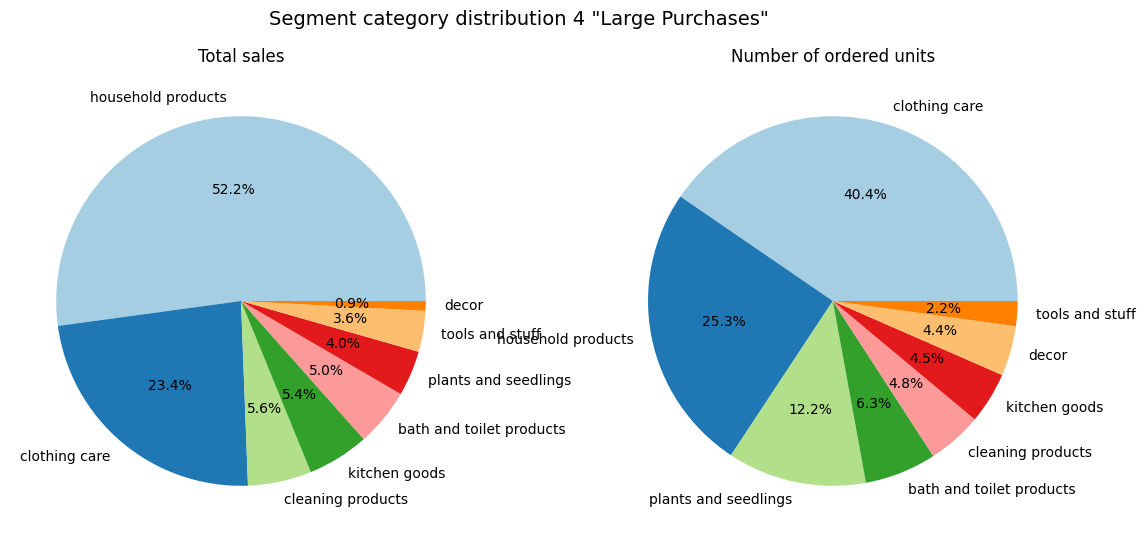

In [101]:
#group data by category
category_seg4 = seg4.groupby('category')[['item_ttl_price', 'quantity']].sum().\
                                                        reset_index().sort_values(by='item_ttl_price', ascending=False)
#draw pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Segment category distribution 4 "Large Purchases"', fontsize=14)

#total sales
sizes = category_seg4['item_ttl_price']
ax1 = axes[0].pie(sizes, labels=category_seg4['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set(title="Total sales")

#sort the data by pieces
category_seg4 = category_seg4.sort_values(by='quantity', ascending=False)

sizes1 = category_seg4['quantity']
ax2 = axes[1].pie(sizes1, labels=category_seg4['category'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1].set(title="Number of ordered units")
plt.show();

The majority of items in this segment were purchased from the "Household products" category - accounting for 52.2% in terms of revenue. In terms of the number of purchased items, this category ranks second and represents 25.3% of the total.

The category "Clothing Care" ranks first in terms of the number of purchased items, accounting for 40.4%.

In [102]:
#visualization of category sales by month
fig = px.bar(seg4.groupby(['date','category'])['item_ttl_price'].sum().reset_index(), \
            x='date', y='item_ttl_price', color='category',
             color_discrete_sequence=px.colors.qualitative.Prism,
            template="plotly_white")
fig.update_layout(title='Segment 4 "Large Purchases" sales by month',
    xaxis_title='date',
    yaxis_title='total sales',
                  width=1000,
                 height=350)
fig.show()

In [103]:
#visualization of the number of orders of categories by month
fig = px.bar(seg4.groupby(['date','category'])['quantity'].sum().reset_index(), \
            x='date', y='quantity', color='category',
             color_discrete_sequence=px.colors.qualitative.Prism,
            template="plotly_white")
fig.update_layout(title='Number of orders by month of segment 4 "Large Purchases"',
    xaxis_title='date',
    yaxis_title='number of orders',
                  width=1000,
                 height=350)
fig.show()

It is difficult to identify a specific seasonality.

## Conclusions and recommendations ##

As part of the project, customer segmentation was conducted to provide recommendations for advertising campaigns.

The initial dataset covered the period from 2018-10-01 to 2020-01-31 and included information about customer purchases: order numbers, items, quantities, and prices.

Data preprocessing was performed, including the removal of implicit duplicates, which accounted for 25.4% of the data. Subsequently, 3.3% of the data was removed during outlier detection. Overall, 28.7% of the original data was removed during preprocessing.

To simplify and systematize the analysis of purchased items, manual categorization of products was conducted. The following categories were identified: Decor, Tools and Miscellaneous, Plants and Seedlings, Bathroom and Toilet Goods, Household Products, Kitchen Goods, Cleaning Supplies, and Clothing Care.

Exploratory data analysis revealed a growth in the active purchasing audience in October 2019. During this period, the number of orders increased; however, we did not observe the same trend in revenue growth.

Based on the database we have the following values:  
* On average (median value), one item is ordered per transaction.
* The median price of one item is 134 rubles. The cheapest item cost 14 rubles, while the most expensive one was priced at 14 917 rubles.
* The median total spent by one customer is 831 rubles.
* Also, on average (median value), one customer made one purchase.
* The average bill is 1091 rubles, with the median value at 645 rubles.

The segmentation was based on calculated metrics: number of purchases, total purchase amount, average order value, average number of unique items per order, average number of units per order, average unit price per order, and average number of categories per order.

A preliminary dendrogram indicated that the optimal segmentation would involve dividing the data into 4 clusters/segments.

As a result of the clustering process, 4 segments were identified:  
* Cluster 1: Buys a Lot of Small Items
* Cluster 2: Returning Customers
* Cluster 3: One-time Buyers
* Cluster 4: Large Purchases   


The most numerous segment is Cluster 3, while Cluster 1 has the fewest users.
Hypothesis testing for equality of the average order value and the average number of units per order between segments showed significant differences in values. Therefore, this segmentation can be further utilized in our work.  
  
Segment 'Small Items' brings less money, then other segments, but it ranks second in terms of the number of items ordered.'Large Purchases' is the most profitable segment,customers from it buy it has the fewest amount of items.
Clients from 'Returned' segment take 2nd place by share of sales and 3d place by amount of ordered units.  
There are no sales after october 2019 by segment 1. We can se sale decline after october 2019 by segment 3. For segment 2 is characterized by an increase in sales amount and the number of orders towards the end of the period.   
  
***Description of segments and recommendations***  
For advertising campaigns, we can use the following segments:

- One-time buyers
- Large purchases
- Returning customers  

I suggest not including the "Small items" segment in our advertising activities, despite their decent average order value and large number of units purchased. Based on the data from the current sample, these customers generate the least revenue for the company. Additionally, the segment is relatively small in size, and the consumption behavior of this audience is subject to seasonality, making it less effective to stimulate sales during certain periods.

**Segment 3 - One-time Buyers**  
They made only one purchase in our store, and on average, customers in this segment spent the least amount of money on shopping. On average, they purchase about three units of products per order.

*Recommendations*  
Products from the "Hosehold products" category are better to include in the newsletter in September-October. From March to May, seasonal offers from the "Plants and Seedlings" category can be included in the newsletter. Additionally, "Kitchen Items" can be tested in the newsletter in November-January.  

**Segment 4 - Large Purchases**  
They make expensive purchases in our store, characterized by the highest average order value and total spending on shopping. However, they usually purchase only one item per transaction.  

*Recommendations*  
When forming an advertising campaign for this segment, the emphasis should be on "household" categories.
First and foremost, these are "Hosehold products" and "Clothing Care".
In July, October, and December, we focus on "Clothing Care", while other months can be mixed.
In September, December, and February, we highlight "Kitchen Items", and from February to January, we focus on "Cleaning Supplies".    


**Segment 1 - Small Items**  
Customers who buy many inexpensive items at once in our store. While their average order value and spending are not the lowest compared to other categories, this is the smallest group, collectively bringing the least profit to the company.

**Segment 2 - Returned**  
Those who made repeat purchases in our store, mostly these repeat purchases occurred in the last 3 months of the analyzed period. Customers in this segment have the lowest average order value, and they tend to purchase from a limited number of categories.   

*Recommendations*  
In the last 3 months, we observe a return of customers and an increase in sales for the following categories: clothing care, household items, kitchenware, plants, and seedlings.

For this segment, I suggest sending out products from the "Household Items" category from July to September. Clothing care products can be promoted in December to March and July. Cleaning products can be highlighted from February to April. Plants and seedlings can be promoted in February, April, May, and September.  